<a href="https://colab.research.google.com/github/momowade221/Segmentation_Valeur_OM/blob/dev/OM_Segmentation_client_OM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CONFIGURATION**

---



In [1]:
!pip install pyspark
# !pip install squarify
# !pip install lifetimes
# !pip install kmodes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=3045764566a42a161065ec1cd1c9bd84740f049edefcc47510a798092573a2ae
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab/Segmentation/
myPath='/content/drive/MyDrive/Colab/Segmentation/#datasets_OM'

import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import *
from pyspark.ml.feature import *
from pyspark.ml import *
from pyspark.ml.clustering import *
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.column import Column

# from lifetimes import BetaGeoFitter
# from lifetimes import GammaGammaFitter
# from lifetimes.plotting import plot_period_transactions

spark = SparkSession.builder.appName("Transactions_OM").getOrCreate()
# Configuration pour permettre l'analyse des dates au format Legacy
# spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
spark

Mounted at /content/drive
/content/drive/MyDrive/Colab/Segmentation


In [3]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import *
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter

# %matplotlib inline

# **PRÉPARATION DES DONNÉES**

---



## **Collection des données**

In [ ]:
#Selection des données sur Hive
""" SELECT * FROM `trusted_om`.`base_transaction_om` WHERE day >= '20230801' AND day <= '20230831'
 ORDER BY RAND() LIMIT 100000; """

In [ ]:
# #Importation des CSV
# path='/content/drive/MyDrive/Colab/Segmentation/#datasets_OM'
# file_list=['2022_2.csv', '2022_3.csv','2022_4.csv','2022_5.csv','2022_6.csv','2022_7.csv',  '2022_8.csv', '2022_8.csv','2022_9.csv','2022_10.csv','2022_11.csv','2022_12.csv','2023_1.csv','2023_2.csv','2023_3.csv','2023_4.csv','2023_5.csv','2023_6.csv','2023_7.csv', ]
# df_agg = spark.read.csv(f'{path}/2022_1.csv', header=True)
# for csv_file in file_list:x
#   df = spark.read.csv(f'{path}/{csv_file}', header=True, inferSchema=True)
#   df_agg = df_agg.union(df)

# df_agg.write.csv('#datasets_OM/trusted_om.base_transaction.csv', header=True, mode='overwrite')
# df_agg.toPandas().to_csv('#datasets_OM/trusted_om.transactions.csv', index=False)
# # Show the RFM DataFrame
# df_agg.show()

In [4]:
def df_load(path, table):
    # Charger le DataFrame depuis le fichier CSV avec les colonnes existantes
    df_loaded= spark.read.csv(f'{path}', header=True)
    # BaseTransaction OM - Renommer les colonnes
    new_column_names = [col_name.replace(f"{table}.", "") for col_name in df_loaded.columns]
    df_loaded = df_loaded.toDF(*new_column_names)
    return df_loaded


def pd_load(path, table):
    # Charger le DataFrame depuis le fichier CSV avec les colonnes existantes
    pd_loaded = pd.read_csv(path)
    # Renommer les colonnes
    pd_loaded.columns = [col.replace(f"{table}.", "") for col in pd_loaded.columns]
    return pd_loaded

#OM
df_transaction_om = df_load(f'{myPath}/base_transaction_om_merge.csv', "base_transaction_om")
pd_transaction_om = pd_load(f'{myPath}/base_transaction_om_merge.csv', "base_transaction_om")
#OEM
df_transaction_oem=df_load(f'{myPath}/base_transaction_oem.csv',"base_transaction_oem")

#Transactions_OM
df_transactions=df_load(f'{myPath}/trusted_om.transactions.csv',"transactions")

#Redefined reporting
df_segment_recharge=df_load(f'{myPath}/refined_reporting.segment_recharge.csv',"segment_recharge")
pd_segment_recharge=pd_load(f'{myPath}/refined_reporting.segment_recharge.csv',"segment_recharge")

#SICO
df_sico=df_load(f'{myPath}/trusted_sicli.sico.csv',"sico")
pd_sico = pd_load(f'{myPath}/trusted_sicli.sico.csv',"sico")

#Segment palier
df_segment_palier=df_load(f'{myPath}/segment_palier.csv',"")

#Localisaion
df_localisation=df_load(f'{myPath}/localisation.csv', 'location_day')
pd_localisation=pd_load(f'{myPath}/localisation.csv', 'location_day')

## **Exploration des données**

---



### Définition des fonctions d'exploration

In [ ]:
def df_info(df: DataFrame):
   # Informations sur le schéma du DataFrame
   ############ Info ###########")
   df.printSchema()

   # Noms des colonnes
   ############ Colonnes ###########")
   print(df.columns)

   # Dimensions (nombre de lignes et de colonnes)
   ############ Dimensions ###########")
   num_rows = df.count()
   num_cols = len(df.columns)
   print(f"\n \n  Nombre de lignes : {num_rows}, Nombre de colonnes : {num_cols}")

   # Afficher les premières lignes (les 5 premières lignes sans troncature)
   ############ Premières lignes ###########")
   df.show(5, truncate=False)  # Affiche les 5 premières lignes sans troncature

   # Afficher les dernières lignes (les 5 dernières lignes triées par la première colonne en ordre décroissant)
   print("\n########### Dernières lignes ###########")
   df.orderBy(df.columns[0], ascending=False).show(5, truncate=False)  # Affiche les 5 dernières lignes

   # Statistiques sommaires (quantiles) du DataFram
   print("\n########### Statistiques sommaires ###########")
   df.summary().show()


def df_info_detailed(df:DataFrame):
  df_info(df)

  # Données manquantes (NA)
  print("\n########### Données manquantes ###########")
  # Compter le nombre de valeurs manquantes (NA) par colonne
  count_NA = df.agg(*[sum(df[c].isNull().cast("int")).alias(c) for c in df.columns])
  # Afficher le résultat
  print("Le nombre de colonnes qui contiennent des valeurs manquantes (NA)")
  count_NA.show()

  # Compter les occurrences de "NULL" dans chaque colonne
  count_exprs = [expr(f"sum(case when {c} like '%NULL%' then 1 else 0 end) as {c}_count") for c in df.columns]
  print("Le nombre de lignes qui contiennent la chaîne 'NULL'")
  count_NULL = df.select(*count_exprs)
  count_NULL.show()

  # Données dupliquées
  print("\n########### Données dupliquées ###########")

  # Find rows where all column values are identical
  duplicate_rows=df.groupBy(*df.columns).agg(count("*").alias("count"))
  duplicate_rows = duplicate_rows.filter(duplicate_rows["count"] > 1).select(*df.columns)

  if duplicate_rows.count()==0:
    print("Aucune ligne dupliquée trouvée")
  else:
    print(f"Nombre de données dupliquées : {duplicate_rows.count()}")
    # Show the rows with identical value
    duplicate_rows.show()

#Fonction pour afficher un DataFrame PySpark sous forme de Pandas DataFrame
def printdf(df):
    return df.toPandas()


In [ ]:
import pandas as pd

# Fonction pour afficher des informations sur un DataFrame Pandas
def df_info_pandas(df):

    df=df.toPandas()
    # Informations sur le schéma du DataFrame
    print("########### Info ###########")
    df.dtypes

    # Noms des colonnes
    print("########### Colonnes ###########")
    df.columns

    # Dimensions (nombre de lignes et de colonnes)
    print("########### Dimensions ###########")
    num_rows, num_cols = df.shape
    print(f"\n \n  Nombre de lignes : {num_rows}, Nombre de colonnes : {num_cols}")

    # Afficher les premières lignes (les 5 premières lignes)
    print("########### Premières lignes ###########")
    df.head()

    # Afficher les dernières lignes (les 5 dernières lignes)
    print("########### Dernières lignes ###########")
    df.tail()

    # Statistiques sommaires (descriptives) du DataFrame
    print("\n########### Statistiques sommaires ###########")
    df.describe()

# Fonction pour afficher des informations détaillées sur un DataFrame Pandas
def df_info_detailed_pandas(df):
    df_info_pandas(df)

    # Données manquantes (NA)
    print("\n########### Données manquantes ###########")
    # Compter le nombre de valeurs manquantes (NA) par colonne
    missing_data = df.isnull().sum()
    print("Nombre de valeurs manquantes par colonne :")
    print(missing_data)

    # Compter les occurrences de "NULL" dans chaque colonne
    count_NULL = df.apply(lambda col: col.str.contains('NULL').sum())
    print("Nombre d'occurrences de 'NULL' par colonne :")
    print(count_NULL)

    # Données dupliquées
    print("\n########### Données dupliquées ###########")
    duplicate_rows = df[df.duplicated(keep=False)]

    if duplicate_rows.shape[0] == 0:
        print("Aucune ligne dupliquée trouvée")
    else:
        print(f"Nombre de données dupliquées : {duplicate_rows.shape[0]}")
        print("Lignes avec données dupliquées :")
        print(duplicate_rows)

# Fonction pour afficher un DataFrame Pandas
def printdf_pandas(df):
    return df


In [ ]:
# from pyspark.sql import functions as F
def df_colonne_info(df: DataFrame, colonne):
    # Nombre de valeurs distinctes dans la colonne
    colonne_count = df.select(colonne).distinct().count()

    # Récupérer le type de données de la colonne
    colonne_type = df.schema[colonne].dataType

    # Affichage des informations
    print(f" *****Informations sur la colonne ___{colonne}___: *****")
    # Valeurs distinctes de la colonne
    print(f"Les valeurs distinctes sont:")
    df.select(colonne).distinct().show(truncate=False)

    print(f"Nombre de valeurs distinctes : {colonne_count}")

    if isinstance(colonne_type, (FloatType,DecimalType, IntegerType)):
        # Statistiques de base sur la colonne (moyenne, écart type, minimum, maximum)
        mean = df.select(mean(colonne)).first()[0]
        stddev = df.select(stddev(colonne)).first()[0]
        min_value = df.select(min(colonne)).first()[0]
        max_value = df.select(max(colonne)).first()[0]

        # Somme des valeurs dans la colonne
        sum_value = df.select(sum(colonne)).first()[0]

        # Médiane de la colonne
        median = df.approxQuantile(colonne, [0.5], 0.01)[0]

        # 1er quartile (Q1) et 3e quartile (Q3)
        quartiles = df.approxQuantile(colonne, [0.25, 0.75], 0.01)
        q1, q3 = quartiles

        print(f"Valeur moyenne : {mean}")
        print(f"Écart type : {stddev}")
        print(f"Valeur minimale : {min_value}")
        print(f"Valeur maximale : {max_value}")
        print(f"Somme des valeurs : {sum_value}")
        print(f"Médiane : {median}")
        print(f"1er quartile (Q1) : {q1}")
        print(f"3e quartile (Q3) : {q3}")
    else:
        print("Les calculs statistiques ne sont pas applicables car le type de données n'est pas numérique.")

    print("-------------------------------------------------------")


In [ ]:
def plot_colonne_distribution(data, colonne):
    fig, ax = plt.subplots(1, 1, figsize=(20, 8))
    sns.set(style="whitegrid")

    custom_palette = sns.color_palette("husl")

    sns.countplot(x=colonne, data=data, palette=custom_palette)

    total_count = len(data)

    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total_count)
        ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

    ax.set_ylabel('Nombre de clients')
    ax.set_title(f"Répartition des clients par {column}")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.tick_params(axis='both', labelsize=14)

    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_colonne_heatmap(data, colonne):
    # Comptez le nombre total de clients
    total_count = len(data)

    # Créez un DataFrame de fréquence des valeurs dans la colonne
    value_counts = data[colonne].value_counts().reset_index()
    value_counts.columns = [colonne, "Count"]

    # Créez un pivot table pour préparer les données au format heatmap
    pivot_table = value_counts.pivot_table(index=None, columns=colonne, values="Count", aggfunc="sum", fill_value=0)

    # Convertissez les valeurs en pourcentage par rapport au total
    pivot_table_percentage = (pivot_table / total_count) * 100

    fig, ax = plt.subplots(figsize=(15, 8))
    sns.set(style="whitegrid")

    # Utilisez la fonction heatmap de Seaborn pour afficher le tableau heatmap en pourcentage
    sns.heatmap(pivot_table_percentage, annot=True, fmt=".1f", cmap="YlGnBu", cbar=False)

    ax.set_xlabel(colonne)
    ax.set_ylabel("Pourcentage de clients")
    ax.set_title(f"Répartition des clients par {colonne} en pourcentage")

    plt.show()

### Exploration de la table **Base_transaction_OM**

In [ ]:
df_info(df_transaction_om)

In [ ]:
import pandas as pd


# Define the table name (similar to your "table" variable in Spark)
table = 'base_transaction_om'
df=pd_transaction_om
# Remove the table name prefix and create new column names
new_column_names = [col_name.replace(f"{table}.", "") for col_name in df.columns]

# Rename the columns in the DataFrame
df= df.rename(columns=dict(zip(df.columns, new_column_names)))

# Exclude specific columns from the summary
columns_to_exclude = ["destinataire", "ingest_date", "month", "year","day", "description","fees", "status","transactionid" ]
df.drop(columns=columns_to_exclude).describe(include="all")


In [ ]:
print(df_transaction_om.columns)

### Exploration de la table **Base_transaction_OEM**

In [ ]:
df_info(df_transaction_oem)

In [ ]:
df_colonne_info(df=df_transaction_oem, colonne="ca_ttc")

### Exploration de la table **Transaction_OM**

In [ ]:
df_info(df_transactions)

In [ ]:
df_colonne_info(df_transactions,"receiver_msisdn")

In [ ]:
df_transactions.select("receiver_state").distinct().show()

### Exploration de la table **Segment_recharge**

In [ ]:
import pandas as pd


# Define the table name (similar to your "table" variable in Spark)
table = 'segment_recharge'
df=pd_segment_recharge
# Remove the table name prefix and create new column names
new_column_names = [col_name.replace(f"{table}.", "") for col_name in df.columns]

# Rename the columns in the DataFrame
df= df.rename(columns=dict(zip(df.columns, new_column_names)))

# Exclude specific columns from the summary
columns_to_include = ["nd","date_naissance","date_debut_engagement","type_contrat","statut"]
df.describe(include="all")


In [ ]:
df_info(df_segment_recharge)
# df_info_detailed(df_segment_recharge)

In [ ]:
df_colonne_info(df_segment_recharge,"segment_recharge")

In [ ]:
# Trouvez l'année maximale
max_year = df_segment_recharge.agg({"year": "max"}).collect()[0][0]

# Filtrer le DataFrame pour obtenir les lignes avec l'année maximale
max_month = df_segment_recharge.filter(col("year") == max_year)\
            .agg({"month": "max"}).collect()[0][0]

df_latest_segment_recharge = df_segment_recharge.filter((col("year") == max_year) & (col("month") == max_month))
df_latest_segment_recharge.show()

In [ ]:
list_col= df_segment_recharge.columns
for col in list_col:
  df_colonne_info(df_segment_recharge, list_col)


### Exploration de la table **Sico**

In [ ]:
import pandas as pd


# Define the table name (similar to your "table" variable in Spark)
table = 'sico'
df=pd_sico
# Remove the table name prefix and create new column names
new_column_names = [col_name.replace(f"{table}.", "") for col_name in df.columns]

# Rename the columns in the DataFrame
df= df.rename(columns=dict(zip(df.columns, new_column_names)))

# Exclude specific columns from the summary
columns_to_include = ["nd","date_naissance","date_debut_engagement","type_contrat","statut"]
df[["nd","date_naissance","date_debut_engagement","type_contrat","statut"]].describe(include="all")


In [ ]:
df_info(df_sico)

In [ ]:
def clean_dataset(df_cli: DataFrame) :
    # Handle missing values by dropping rows with missing values
    cleaned_df = df_cli.dropna()

    # Remove duplicates
    cleaned_df = cleaned_df.dropDuplicates()

    return cleaned_df

# Usage example:
cleaned_df = clean_dataset(df_sico)
cleaned_df.show()


In [ ]:
df_sico.select("nd","date_naissance").filter((col("nd")==417040)).show()

In [ ]:
taken_columns_sico = [ 'nd', 'date_naissance', 'date_debut_engagement', 'statut']
df_sic = df_sico.select(taken_columns_sico) \
            .filter(df_sico["statut"]=="ACTIF")  \
            .withColumnRenamed("nd", "numero") \
            .drop("statut")
df_sic= df_sic.withColumn("Age", year(current_date()) - year("date_naissance")).drop("date_naissance")\
          .withColumn("Anciennete",  year(current_date()) - year("date_debut_engagement")).drop("date_debut_engagement")

df_sic.show()

In [ ]:
df_sico.withColumn("entite",
          when((col("civilite") == "Mademoiselle") | (col("civilite") == "Madame") | (col("civilite") == "Monsieur"), "Personne physique")
          .when((col("civilite") == "Soci�t�") | (col("civilite") == "Etablissements") | (col("civilite") == "Service"), "Personne morale")
          .otherwise("Autre")) \
          .drop("civilite") \
          .show()

### Exploration de la table **Segment Palier**

In [ ]:
df_info(df_segment_palier)

In [ ]:
df_segment_palier.printSchema()

### Localisation

In [ ]:
df_localisation.printSchema()

In [ ]:
df_localisation.show()

In [ ]:
# Sélectionnez les top 15 communes_arrondissements
df_top_villes = df_localisation.groupBy("commune_arrondissement").count().orderBy(col("count").desc()).limit(15)

# Sélectionnez les clients dans les communes_arrondissements spécifiées
df_clients_top_villes = df_localisation.select("msisdn", "commune_arrondissement") \
    .filter(col("commune_arrondissement").isin([row.commune_arrondissement for row in df_top_villes.collect()]))

# Renommez la colonne commune_arrondissement en "ville"
df_clients_top_villes = df_clients_top_villes.withColumnRenamed("commune_arrondissement", "ville")

# Remplacez les valeurs spécifiques
replacements = {
    "NDAME": "TOUBA",
    "NIAYES": "KEUR MASSAR",
    "PIKINE DAGOUDANE": "PIKINE"
}

for old_value, new_value in replacements.items():
    df_clients_top_villes = df_clients_top_villes.na.replace(old_value, new_value, "ville")

# Affichez le DataFrame résultant
df_clients_top_villes.show()

In [ ]:
df_colonne_info(df_clients_top_villes,"ville")

In [ ]:
# Utilisation de la fonction avec les variables nécessaires
plot_colonne_distribution(pd_localisation, "departement")

In [ ]:
import pandas as pd

def pourcentage_clients_par_colonne(dataframe, territoire):
    # Groupez le DataFrame par la colonne spécifiée et comptez le nombre de clients dans chaque région.
    territoire_counts = dataframe[territoire].value_counts()

    # Calculez le pourcentage de clients par région en divisant le nombre de clients dans chaque région par le nombre total de clients.
    total_clients = len(dataframe)
    region_percentages = (territoire_counts / total_clients) * 100

    # Créez un nouveau DataFrame pour afficher les résultats sous forme de tableau.
    result_df = pd.DataFrame({territoire: region_percentages.index, 'Pourcentage de Clients': region_percentages.values})

    # Triez le DataFrame par pourcentage décroissant.
    result_df = result_df.sort_values(by='Pourcentage de Clients', ascending=False)

    # Formatez la colonne "Pourcentage de Clients" avec le signe '%' et deux chiffres après la virgule.
    result_df['Pourcentage de Clients'] = result_df['Pourcentage de Clients'].apply(lambda x: f'{x:.2f}%')

    # Réinitialisez l'index du DataFrame résultant.
    result_df = result_df.reset_index(drop=True)

    return result_df

resultat = pourcentage_clients_par_colonne(pd_localisation, 'commune_arrondissement')
pd.set_option('display.max_rows', None)
resultat


In [ ]:
ville_set=collect_set(df_localisation["ca_cr_commune"]).alias("villes")

df_location = df_localisation.groupBy("msisdn").agg(ville_set, size(ville_set).alias("nombre_villes"))
df_location.show()

## **Prétraitement des données**

### Transformation des données

In [5]:
def df_transform(df: DataFrame):
    # Transformation en minuscule de la colonne Type transaction
    df = df.withColumn("typetransaction", lower(df["typetransaction"]))

    # Sélection des Colonnes Nécessaires
    no_taken_columns = ["fees", "operation", "date",  "ingest_date", "description", "status", "statuscode"]
    taken_columns = ["transactionid", "msisdn", "destinataire", "montant","year", "month", "day","typetransaction", "titre",  "channel", "statuscode"]
    df = df.select(taken_columns)

    # Sélection des colonnes nécessaires et renommage
    df = df.select(taken_columns) \
        .withColumnRenamed("msisdn", "numero") \
        .withColumnRenamed("day", "date") \
        .withColumnRenamed("titre", "type_service")

    # Supprimer les lignes où 'Montant' est égal à "NULL"
    df = df.filter(df["montant"] != "NULL")

    # Conversion des données des colonnes Date et Montant
    df = df.withColumn("montant", df["montant"].cast(FloatType()))
    df = df.withColumn("date", to_date(df["date"], "yyyyMMdd"))

     # Données manquantes et standardisation sur la colonne TypesTransaction
    df = df.withColumn("type_service",
                      when((df["typetransaction"] == "cashin") & (df["type_service"] == "NULL"), "Depot")
                      .when((df["typetransaction"] == "cashin") & (df["type_service"] == "Dépot"), "Depot")
                      .when((df["typetransaction"] == "achat_credit") & (df["type_service"] == "Recharge Crédit"), "Recharge Credit")
                      .when((df["typetransaction"] == "cashout") & (df["type_service"] == "NULL"), "Retrait")
                      .when((df["typetransaction"] == "transfert") & (df["type_service"] == "NULL"), "Transfert")
                      .when((df["typetransaction"] == "cashinother") & (df["type_service"] == "NULL"), "Autre retrait")
                      .when((df["typetransaction"] == "cashout_confirm") | (df["typetransaction"] == "cashout") & (df["type_service"] == "Retrait d'argent"), "Retrait")
                      .when((df["typetransaction"] == "paiement_marchand") & (df["type_service"] == "NULL"), "Paiement marchand")
                      .otherwise(df["type_service"])
                      )
     # Définissez le dictionnaire de services
    services = {
        'service_financier': ["OM vers Banque", "Retrait avec code", "Retrait", "Banque vers OM", "Depot", "Envoi", "Transfert international", "Autre retrait", "Transfert"],
        'paiement': ["Rapido", "Paiement marchand", "Ubipharm", "Sunna Moon", "Canal +", "SEN'EAU", "AQUATECH", "ISM", "Carte TotalEnergies", "SONATELFIXE", "SDE", "Woyofal", "SONATELMOBILE", "SEN", "Recharge Xeweul", "SAMA MBEY", "ILEMEL"],
        'achat': ["Recharge Credit", "Pass Illimix", "Pass Internet", "Vente Crédit"],
        'don_cotisation': ["Dons et cotisations"]
    }
    df_transformed= df.withColumn("categorie_service",df["type_service"])
    # Utilisez la fonction `withColumn` pour ajouter la colonne "type_service" en fonction des catégories
    for categorie, liste_services in services.items():
        df_transformed = df_transformed.withColumn("categorie_service", when(df_transformed["categorie_service"].isin(liste_services), categorie).otherwise(df_transformed["categorie_service"]))


    return df_transformed

### Nettoyage des données

In [6]:
def df_clean(df):

    # Données manquantes sur la colonne channel
    df = df.withColumn("channel", when(df["channel"] == "NULL", "Inconnu").otherwise(df["channel"]))

    # Transactions échoué
    status_success =["200","TS","éffectué"]
    status_failed = ["échoué", "TP", "TF"]

    # Utilisez la fonction "when" pour créer une colonne "reussi"
    df = df.withColumn("statuscode", when(col("statuscode").isin(status_success), "réussi").otherwise("non réussi"))
    # Filtrer les lignes où le statut est "réussi"
    df_reussi = df.filter(col("statuscode") == "réussi")

    # Gestion des données aberrantes
    df = df.filter(df["montant"] >0)
    df = df.filter(df["montant"] <2000000)
    # Gestion des données dupliquées
    df_cleaned = df.dropDuplicates()
    return df_cleaned


###Structuration des données

In [7]:
#Définition des dataframes préparés
df_transformed=df_transform(df_transaction_om)
df_transaction_prepared=df_clean(df_transformed)
df_transaction_prepared.printSchema()

root
 |-- transactionid: string (nullable = true)
 |-- numero: string (nullable = true)
 |-- destinataire: string (nullable = true)
 |-- montant: float (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- date: date (nullable = true)
 |-- typetransaction: string (nullable = true)
 |-- type_service: string (nullable = true)
 |-- channel: string (nullable = true)
 |-- statuscode: string (nullable = false)
 |-- categorie_service: string (nullable = true)



###Sauvegarde des données

In [ ]:
def df_save(df: DataFrame, pathForSave) :
  df_saved=df.toPandas().to_csv(pathForSave, index=False)
  return df_saved

df_saved=df_save(df_transaction_prepared, '#datasets_OM/base_transaction_om_prepared.csv')

In [ ]:
pd_transaction_prepared=pd.read_csv('#datasets_OM/base_transaction_om_prepared.csv')
pd_transaction_prepared.info()

In [ ]:
df_info(df_transaction_prepared)

### Visualisations

In [ ]:
df_info_detailed(df_transaction_prepared)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Supposons que vous ayez un DataFrame Pandas 'pd_transaction_om' avec les données
pd_transaction_om=pd_transaction_om
# Créez une figure avec des sous-graphiques
fig, axes = plt.subplots(2, 1, figsize=(10, 18))


# Sous-graphique 1 : Distribution des Titres
titre_counts = pd_transaction_om['TitreY'].value_counts()
axes[0].bar(titre_counts.index, titre_counts.values, color='lightcoral')
axes[0].set_title('Distribution des Titres')
axes[0].set_xlabel('Titre')
axes[0].set_ylabel('Fréquence')
axes[0].tick_params(axis='x', rotation=45)

# Sous-graphique 2 : Distribution des Canaux
channel_counts = pd_transaction_om['channel'].value_counts()
axes[1].bar(channel_counts.index, channel_counts.values, color='lightblue')
axes[1].set_title('Distribution des Canaux')
axes[1].set_xlabel('Canal')
axes[1].set_ylabel('Fréquence')
axes[1].tick_params(axis='x', rotation=45)


# # Sous-graphique 1 : Distribution des montants (Intervalles de 10,000)
# montants = pd_transaction_om['montant'].astype(float)
# bins = range(0, int(montants.max()) + 10000, 10000)
# hist, edges = np.histogram(montants, bins=bins)
# axes[2].hist(montants, bins=bins, color='skyblue', edgecolor='black')
# axes[2].set_xticks(edges)
# axes[2].set_xticklabels([f'{edges[i]:,.0f}-{edges[i+1]:,.0f}' for i in range(len(edges) - 1)])
# axes[2].set_title('Distribution des montants (Intervalles de 10,000)')
# axes[2].set_xlabel('montant')
# axes[2].set_ylabel('Fréquence')


# Ajustez l'espacement entre les sous-graphiques
plt.tight_layout()

# Affichez les sous-graphiques
plt.show()


# **MODÉLISATION POUR LA SEGMENTATION MULTISERVICE**

---



### Méthode

In [8]:
def segmenter_multiservice(df: DataFrame):
    # Groupement par client (Numéro) et collecte des types de transactions uniques et des canaux uniques
    channel_set = collect_set(df["channel"]).alias("canaux")
    service_set=collect_set(df["type_service"]).alias("services")
    categorie_set=collect_set(df["categorie_service"]).alias("categories_services")
    multiservice_segmentation = df.groupBy("numero").agg(
        service_set,
        size(service_set).alias("nombre_services"),
        categorie_set,
        size(categorie_set).alias("nombre_categories"),
        channel_set,
        size(channel_set).alias("nombre_canaux"),
        sum("montant").alias("montant_total")

    )

    # Définir la valeur du seuil
    seuil = 1
    # Calcul du segment
    multiservice_segmentation = multiservice_segmentation.withColumn("segment_service", when(multiservice_segmentation["nombre_services"] <= seuil, "Monoservice").otherwise("Multiservice"))
    multiservice_segmentation = multiservice_segmentation.withColumn("segment_categorie", when(multiservice_segmentation["nombre_categories"] <= seuil, "Monocategorie").otherwise("Multicategorie"))
    return multiservice_segmentation


# Appeler la fonction pour calculer la segmentation des clientsd
df_segment_multiservice = segmenter_multiservice(df_transaction_prepared)
pd_segment_multiservice=df_segment_multiservice.toPandas()
# # Afficher le résultat
df_segment_multiservice.printSchema()

root
 |-- numero: string (nullable = true)
 |-- services: array (nullable = false)
 |    |-- element: string (containsNull = false)
 |-- nombre_services: integer (nullable = false)
 |-- categories_services: array (nullable = false)
 |    |-- element: string (containsNull = false)
 |-- nombre_categories: integer (nullable = false)
 |-- canaux: array (nullable = false)
 |    |-- element: string (containsNull = false)
 |-- nombre_canaux: integer (nullable = false)
 |-- montant_total: double (nullable = true)
 |-- segment_service: string (nullable = false)
 |-- segment_categorie: string (nullable = false)



In [9]:
pd_segment_multiservice.to_csv('#datasets_OM/segments_multiservice.csv', index=False)

In [10]:
def profil_client_multiservice(numero):
    # Calcul de la segmentation multiservice pour l'ensemble des clients
    # profil_client_multiservice = segmenter_multiservice(df_transaction_prepared)
    profil_client = df_segment_multiservice
    # Filtrage du profil du client en fonction du numéro donné
    profil_client = profil_client.filter(profil_client["numero"] == numero).collect()
    # Conversion du profil du client en dictionnaire et collecte du résultat
    profil_client = [row.asDict() for row in profil_client]

    # Retourne le premier (et unique) élément du résultat, qui est un dictionnaire
    return profil_client


In [11]:
# Appel de la fonction pour obtenir le profil du client
profil_client_multiservice(numero=1000339)

[{'numero': '1000339',
  'services': ['Retrait', 'Transfert'],
  'nombre_services': 2,
  'categories_services': ['service_financier'],
  'nombre_categories': 1,
  'canaux': ['USSD'],
  'nombre_canaux': 1,
  'montant_total': 51050.0,
  'segment_service': 'Multiservice',
  'segment_categorie': 'Monocategorie'}]

### Visualisations

In [ ]:
import pandas as pd

# Supposons que vous avez déjà un DataFrame pd_rfm_segments
# Vous pouvez l'initialiser comme suit
# pd_rfm_segments = pd.read_csv('votre_fichier.csv')

# Groupement par segment_RFM et calcul des statistiques pour chaque groupe
segment_stats = pd_segment_multiservice.groupby('segment_service').agg({
    'numero': 'count',  # Nombre de clients
    'nombre_services': ['min', 'max', 'mean'],  # Min, max et moyenne du nombre de services
    'montant': ['min', 'max', 'mean']  # Min, max et moyenne du chiffre d'affaires
})

# Renommer les colonnes pour plus de clarté
segment_stats.columns = ['Nombre_clients',
                         'Nb_services_min', 'Nb_services_max', 'Nb_services_moy',
                         'CA_min', 'CA_max', 'CA_moy']

# Calculer le pourcentage des clients et le convertir en pourcentage (avec deux chiffres après la virgule)
total_clients = segment_stats['Nombre_clients'].sum()
segment_stats['%Clients'] = (segment_stats['Nombre_clients'] / total_clients * 100).apply(lambda x: f'{x:.2f} %')
segment_stats = segment_stats.drop('Nombre_clients', axis=1)  # Supprimer la colonne Nombre_clients

# Définir une fonction pour formater avec un espace comme séparateur des milliers
def format_with_space(value):
    return f"{value:,.0f}".replace(",", " ")

# Appliquer la fonction de formatage aux colonnes appropriées
formatted_segment_stats = segment_stats.copy()
formatted_segment_stats = formatted_segment_stats.applymap(lambda x: format_with_space(x) if isinstance(x, (int, float)) else x)

# Utiliser Styler.format pour afficher le DataFrame avec le format des milliers
formatted_segment_stats.style.format(formatter=None)


In [ ]:
pd_segment_multiservice

In [ ]:
df_pre=pd_transaction_prepared[["numero","typetransaction", "type_service", "channel" ,"statuscode"]].rename(columns={"statuscode":"Status_code"})
df_transaction_prepared.select("type_service").withColumnRenamed("type_service","Service").distinct().toPandas()

In [ ]:
df_info(df_segment_multiservice)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Créez un countplot avec une palette de couleurs personnalisée
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.set(style="whitegrid")

custom_palette = sns.color_palette("Set1")

sns.countplot(x="segment_service", data=pd_segment_multiservice, palette=custom_palette)

# Calculez le nombre total de clients
total_count = len(pd_segment_multiservice)

# Annoter les barres avec des pourcentages
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total_count)
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

# Modifier l'étiquette de l'axe des ordonnées et le titre
ax.set_ylabel('Nombre de clients')
ax.set_title('Répartition des clients par nombre de services')

plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convertir le dataframe Spark en un DataFrame Pandas
# Assurez-vous que vous avez déjà initialisé Spark et chargé les données dans pd_segment_multiservice

# Regroupez par le nombre de services et calculez le chiffre d'affaires total
service_grouped = pd_segment_multiservice.groupby('Segment_service')['montant'].sum().reset_index()

# Calculez le pourcentage du chiffre d'affaires pour chaque nombre de services
total_montant = service_grouped['montant'].sum()
service_grouped['Pourcentage_montant'] = (service_grouped['montant'] / total_montant) * 100

# Créez une palette de couleurs diversifiée
diverse_palette = sns.color_palette("rocket", n_colors=len(service_grouped))

# Créez un graphique à barres en utilisant la palette de couleurs diversifiée
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(service_grouped.index, service_grouped['Pourcentage_montant'], color=diverse_palette)
ax.set_xlabel('Segments')
ax.set_ylabel('Pourcentage du Chiffre d\'Affaire')
ax.set_title('Pourcentage du Chiffre d\'Affaire par segment')

# Personnalisez les étiquettes de l'axe des abscisses
ax.set_xticks(service_grouped.index)
ax.set_xticklabels(service_grouped['Segment_service'])

# Annoter les barres avec les pourcentages
for i, percentage in enumerate(service_grouped['Pourcentage_montant']):
    ax.annotate(f'{percentage:.2f}%', (service_grouped.index[i], percentage), ha='center', va='bottom')

plt.show()


# **MODÉLISATION POUR LA SEGMENTATION VALEUR RFM**

---



### Feature engineering

In [ ]:
latest_date = to_date(lit("2023/08/17"), 'yyyy/MM/dd')
def df_rfm_prepare(df):
    # Sélection des colonnes pertinentes pour RFM : numero, montant, date
    df_rfm = df.select("numero", "montant", "date")

    # Calcul de la date maximale dans le DataFrame
    max_date = df_rfm.agg(max("date").alias("max_date")).collect()[0]["max_date"]

    # Convert the max_date string to a date object
    # latest_date = datetime.strptime(max_date, '%Y-%m-%d')

    # Calcul de la récence (Recency)
    df_recency = df_rfm.groupBy("numero").agg(
        datediff(lit(latest_date), max(df["date"])).alias("recence")
    )

    # Calcul de la fréquence (Frequency, le nombre de transactions)
    df_frequency = df_rfm.groupBy("numero").agg(
        count("*").alias("frequence")
    )

    # Calcul de la valeur monétaire (Monetary Value, montant total des transactions)
    df_monetary = df_rfm.groupBy("numero").agg(
        sum("montant").alias("montant")
    )

    # Jointure des DataFrames Recency, Frequency et Monetary
    df_rfm = df_recency.join(df_frequency, "numero", "inner").join(df_monetary, "numero", "inner")

    return df_rfm

In [ ]:
df_rfm_prepared=df_rfm_prepare(df_transaction_prepared)
# pd_rfm_segments_prepared=df_rfm_prepared.toPandas()

### Calcul des scores

In [ ]:
def calculer_scores_rfm(df_rfm):
    # Calculer les quantiles pour les caractéristiques recence, frequence et montant
    quantiles = df_rfm.approxQuantile(["recence", "frequence", "montant"], [0.2, 0.4, 0.6, 0.8], 0.01)

    # Définir des expressions conditionnelles pour attribuer les scores R, F, et M
    df_rfm = (df_rfm
        .withColumn("score_R",  when(df_rfm["recence"] <= quantiles[0][0], lit(5))
                                .when(df_rfm["recence"] <= quantiles[0][1], lit(4))
                                .when(df_rfm["recence"] <= quantiles[0][2], lit(3))
                                .when(df_rfm["recence"] <= quantiles[0][3], lit(2))
                                .otherwise(lit(1)))
        .withColumn("score_F", when(df_rfm["frequence"] >= quantiles[1][3], lit(5))
                                .when(df_rfm["frequence"] >= quantiles[1][2], lit(4))
                                .when(df_rfm["frequence"] >= quantiles[1][1], lit(3))
                                .when(df_rfm["frequence"] >= quantiles[1][0], lit(2))
                                .otherwise(lit(1)))
        .withColumn("score_M", when(df_rfm["montant"] >= quantiles[2][3], lit(5))
                                .when(df_rfm["montant"] >= quantiles[2][2], lit(4))
                                .when(df_rfm["montant"] >= quantiles[2][1], lit(3))
                                .when(df_rfm["montant"] >= quantiles[2][0], lit(2))
                                .otherwise(lit(1)))
                )
    df_rfm=df_rfm.withColumn("score_RFM", concat(df_rfm["score_R"].cast(StringType()), df_rfm["score_F"].cast(StringType()), df_rfm["score_M"].cast(StringType())))
    return df_rfm


### Profilage des segments

In [ ]:
def profiler_segments_rfm(df_rfm):
    segments = {
        'Champion': ['555', '554', '544', '545', '454', '455', '445'],
        'Fidèle': ['543', '444', '435', '355', '354', '345', '344', '335'],
        'Fidèle potentiel': [
            '553', '551', '552', '541', '542', '533', '532', '531', '452', '451', '442',
            '441', '431', '453', '433', '432', '423', '353', '352', '351', '342', '341', '333', '323'
        ],
        'Prometteur': [
            '525', '524', '523', '522', '521', '515', '514', '513', '425', '424', '413', '414',
            '415', '315', '314', '313'
        ],
        'À surveiller': ['535', '534', '443', '434', '343', '334', '325', '324'],
        'À risque': [
            '255', '254', '245', '244', '253', '252', '243', '242', '235', '234', '225', '224',
            '153', '152', '145', '143', '142', '135', '134', '133', '125', '124'
        ],
        'En sommeil': [
            '332', '322', '233', '232', '223', '222', '132', '123', '122', '212', '211'
        ],
        'Sur le point de dormir': [
            '331', '321', '312', '221', '213', '231', '241', '251'
        ],
        # 'Engagés en sommeil': ["111", "112", "121", "131", "141", "151"],
        'Perdu': ['111', '112', '121', '131', '141', '151'],
        'Nouveau': ['512', '511', '422', '421', '412', '411', '311']
    }

    # Utiliser une expression conditionnelle pour attribuer les segments en fonction des scores RFM
    df_rfm = (df_rfm
        .withColumn('segment_RFM',
            when(df_rfm['score_RFM'].isin(segments['Champion']), lit('Champion'))
            .when(df_rfm['score_RFM'].isin(segments['Fidèle']), lit('Fidèle'))
            .when(df_rfm['score_RFM'].isin(segments['Fidèle potentiel']), lit('Fidèle potentiel'))
            .when(df_rfm['score_RFM'].isin(segments['Nouveau']), lit('Nouveau'))
            .when(df_rfm['score_RFM'].isin(segments['Prometteur']), lit('Prometteur'))
            .when(df_rfm['score_RFM'].isin(segments['À surveiller']), lit('À surveiller'))
            .when(df_rfm['score_RFM'].isin(segments['À risque']), lit('À risque'))
            .when(df_rfm['score_RFM'].isin(segments['Sur le point de dormir']), lit('Sur le point de dormir'))
            .when(df_rfm['score_RFM'].isin(segments['En sommeil']), lit('En sommeil'))
            # .when(df_rfm['score_RFM'].isin(segments['Engagés en sommeil']), lit('Engagés en sommeil'))
            .when(df_rfm['score_RFM'].isin(segments['Perdu']), lit('Perdu'))
            .otherwise(lit('Autre'))
        )
    )

    return df_rfm


### Test de la méthode RFM

In [ ]:
def segmenter_valeur_rfm(dataFrame: DataFrame):
  # df_transformed=df_transform(dataFrame)
  # df_transaction_prepared=df_clean(df_transformed)
  df_rfm=df_rfm_prepare(dataFrame)
  df_rfm_scores= calculer_scores_rfm(df_rfm)
  df_rfm_segments = profiler_segments_rfm(df_rfm_scores)
  return df_rfm_segments


In [ ]:
df_rfm_segments=segmenter_valeur_rfm(df_transaction_prepared)
# df_rfm_segments.show()

In [ ]:
def segment_client_rfm(numero):
  rfm_result=df_rfm_segments.drop("score_R","score_F","score_M").where(df_rfm_segments["numero"]==numero)
  rfm_result=rfm_result.toJSON().collect()[0]
  return  rfm_result

In [ ]:
segment_client_rfm(1000038)

### Sauvegarde du DataFrame RFM

In [ ]:
#Save to csv
pd_rfm_segments=df_rfm_segments.toPandas()
pd_rfm_segments_sort =pd_rfm_segments.sort_values(["score_RFM"])

In [ ]:
pd_rfm_segments.to_csv('#datasets_OM/segments_rfm.csv', index=False)
# pd.read_csv('#datasets_OM/base_transaction_om_rfm.csv')

### Exploration du Dataframe RFM

In [ ]:
df_info(df_rfm_segments)

In [ ]:
taken_columns_sico = [ 'nd', 'date_naissance', 'date_debut_engagement', 'statut']
df_sic = df_sico.select(taken_columns_sico) \
          .filter(df_sico["statut"]=="ACTIF")  \
          .filter(df_sico["date_naissance"] != "NULL")\
          .withColumnRenamed("nd", "numero") \
          .drop("statut")

df_sic= df_sic.withColumn("anciennete",  year(current_date()) - year("date_debut_engagement"))\
        .withColumn("age", year(current_date()) - year("date_naissance")).drop("date_naissance")\
        .filter(col("age")>15) \
        .filter(col("age")<90) \
        .drop("date_debut_engagement")


# ville_set=collect_set(df_localisation["ca_cr_commune"]).alias("villes")
# df_loc=df_localisation.select("msisdn","ca_cr_commune") \
#                       .groupBy("msisdn").agg(ville_set, size(ville_set).alias("nombre_villes"))\
#                       .withColumnRenamed("msisdn","numero")

df_rfm_joined=df_rfm_segments.drop('score_R','score_F','score_M').join(df_sic,'numero', 'inner')
pd_rfm_joined= df_rfm_joined.toPandas()

In [ ]:
df_rfm_joined.printSchema()

In [ ]:
pd_rfm_joined.describe()

In [ ]:
import pandas as pd

# Define the custom formatting function
def format_with_space(value):
    if isinstance(value, (int, float)):
            return f"{value:,.0f}".replace(",", " ")
    return value

# Select the specific columns and calculate the default summary
selected_columns = ["numero", "recence", "frequence", "montant"]
summary = pd_rfm_segments[selected_columns].describe()

# Apply custom formatting to the summary
formatted_summary = summary.applymap(lambda x: format_with_space(x) if isinstance(x, (int, float)) else x)

# Print the formatted summary
formatted_summary


In [ ]:
import pandas as pd

# Supposons que vous avez déjà un DataFrame pd_rfm_segments
# Vous pouvez l'initialiser comme suit
# pd_rfm_segments = pd.read_csv('votre_fichier.csv')

# Groupement par segment_RFM et calcul des statistiques pour chaque groupe
segment_stats = pd_rfm_segments.groupby('segment_RFM').agg({
    'numero': 'count',  # Nombre de clients
    'recence': ['min', 'max', 'mean'],  # Min, max et moyenne de recence
    'frequence': ['min', 'max', 'mean'],  # Min, max et moyenne de Fréquence
    'montant': ['min', 'max', 'mean']  # Min, max et moyenne de montant
})

# Renommer les colonnes pour plus de clarté
segment_stats.columns = ['Nombre_clients', 'R_min', 'R_max', 'R_moy',
                         'F_min', 'F_max', 'F_moy',
                         'M_min', 'M_max', 'M_moy']

# Calculer le pourcentage des clients et le convertir en pourcentage (avec deux chiffres après la virgule)
total_clients = segment_stats['Nombre_clients'].sum()
segment_stats['%Clients'] = (segment_stats['Nombre_clients'] / total_clients * 100).apply(lambda x: f'{x:.2f} %')
segment_stats = segment_stats.drop('Nombre_clients', axis=1)  # Supprimer la colonne Nombre_clients

# Définir une fonction pour formater avec un espace comme séparateur des milliers
def format_with_space(value):
    return f"{value:,.0f}".replace(",", " ")

# Appliquer la fonction de formatage aux colonnes appropriées
formatted_segment_stats = segment_stats.copy()
formatted_segment_stats = formatted_segment_stats.applymap(lambda x: format_with_space(x) if isinstance(x, (int, float)) else x)

# Utiliser Styler.format pour afficher le DataFrame avec le format des milliers
formatted_segment_stats.style.format(formatter=None)


In [ ]:
import pandas as pd

data = {
    'Segment': ['Champions', 'Fidèles', 'Fidèles potentiels', 'A Surveiller', 'Nouveaux', 'Prometteurs',
                'Sur le point de dormir', 'À Risque', 'En sommeil', 'Perdus'],
    'Activité': [
        "Ont récemment acheté, commandent souvent et dépensent le plus.",
        "Passent régulièrement des commandes. Réactifs aux promotions.",
        "Clients récents qui ont dépensé des sommes importantes.",
        "Clients de base dont le dernier achat remonte à plus d'un mois.",
        "Ont acheté très récemment.",
        "Loyalistes potentiels il y a quelques mois. Dépensent fréquemment et une somme importante. Mais le dernier achat remonte à plusieurs semaines.",
        "Ont fait leur dernier achat il y a longtemps, mais au cours des 4 dernières semaines, ils ont soit visité le site soit ouvert un e-mail.",
        "Ont effectué les plus grosses commandes et souvent. Mais ils ne sont pas revenus depuis longtemps.",
        "Clients qui ont fait des achats plus petits et moins fréquents auparavant, mais qui n'ont rien acheté depuis longtemps.",
        "Ont effectué leur dernier achat il y a longtemps et n'ont pas du tout été actifs au cours des 4 dernières semaines."
    ]
}

df = pd.DataFrame(data)

# Centrer le texte dans la colonne 'Activité' et changer la couleur en bleu et blanc
def highlight_text(text):
    return f'text-align: center;'

styled_df = df.style.applymap(highlight_text)

# Add borders between columns
styled_df.set_properties(**{
    'border': '1px solid white',
    'border-collapse': 'collapse',
    'text-align': 'center'
})


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Given data and segments
data = {
    'Champion': ['555', '554', '544', '545', '454', '455', '445'],
    'Fidèle': ['543', '444', '435', '355', '354', '345', '344', '335'],
    'Fidèle potentiel': [
        '553', '551', '552', '541', '542', '533', '532', '531', '452', '451', '442',
        '441', '431', '453', '433', '432', '423', '353', '352', '351', '342', '341', '333', '323'
    ],
    'Prometteur': [
        '525', '524', '523', '522', '521', '515', '514', '513', '425', '424', '413', '414',
        '415', '315', '314', '313'
    ],
    'À surveiller': ['535', '534', '443', '434', '343', '334', '325', '324'],
    'À risque': [
        '255', '254', '245', '244', '253', '252', '243', '242', '235', '234', '225', '224',
        '153', '152', '145', '143', '142', '135', '134', '133', '125', '124'
    ],
    'En sommeil': [
        '332', '322', '233', '232', '223', '222', '132', '123', '122', '212', '211'
    ],
    'Sur le point de dormir': [
        '331', '321', '312', '221', '213', '231', '241', '251'
    ],
    'Perdu': ['111', '112', '121', '131', '141', '151'],
    'Nouveau': ['512', '511', '422', '421', '412', '411', '311']
}

# Create a DataFrame with two columns: "segment_RFM" and "score_RFM"
df_segments_scores = None

for segment, scores in data.items():
    segment_df_segments_scores = spark.createDataFrame([(segment, score) for score in scores], ["segment_RFM", "score_RFM"])
    if df_segments_scores is None:
        df_segments_scores = segment_df_segments_scores
    else:
        df_segments_scores = df_segments_scores.union(segment_df_segments_scores)

# Assuming you have a DataFrame called df_segments_scores_rfm_segments
# First, group by the "segment_RFM" column and collect the "RFM_score" values into a list
result_df_segments_scores = df_segments_scores.groupBy("segment_RFM").agg(collect_set("RFM_score").alias("score_RFMs"))

# Show the result DataFrame
result_df_segments_scores.toPandas()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Créez un countplot avec une palette de couleurs personnalisée
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
sns.set(style="whitegrid")

custom_palette = sns.color_palette("husl")

sns.countplot(x="segment_RFM", data=pd_rfm_segments, palette=custom_palette)

# Calculez le nombre total de clients
total_count = len(pd_rfm_segments)

# Annoter les barres avec des pourcentages
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total_count)
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

# Modifier l'étiquette de l'axe des ordonnées et le titre
ax.set_ylabel('Nombre de clients')
ax.set_title('Répartition des clients par Segment RFM')

# Rotation des étiquettes de l'axe des abscisses de 45 degrés
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Augmenter la taille de la police
ax.tick_params(axis='both', labelsize=14)

plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Regroupez par le nombre de services et calculez le chiffre d'affaires total
service_grouped = pd_rfm_segments.groupby('segment_RFM')['montant'].sum().reset_index()

# Calculez le pourcentage du chiffre d'affaires pour chaque nombre de services
total_montant = service_grouped['montant'].sum()
service_grouped['Pourcentage_montant'] = (service_grouped['montant'] / total_montant) * 100

# Créez une palette de couleurs diversifiée
diverse_palette = sns.color_palette("husl", n_colors=len(service_grouped))

# Créez un graphique à barres en utilisant la palette de couleurs diversifiée
fig, ax = plt.subplots(figsize=(20, 9))
ax.bar(service_grouped.index, service_grouped['Pourcentage_montant'], color=diverse_palette)
ax.set_xlabel('Segments')
ax.set_ylabel('Pourcentage du Chiffre d\'Affaire')
ax.set_title('Pourcentage du Chiffre d\'Affaire par segment')

# Personnalisez les étiquettes de l'axe des abscisses
ax.set_xticks(service_grouped.index)
ax.set_xticklabels(service_grouped['segment_RFM'])

# Annoter les barres avec les pourcentages
for i, percentage in enumerate(service_grouped['Pourcentage_montant']):
    ax.annotate(f'{percentage:.2f}%', (service_grouped.index[i], percentage), ha='center', va='bottom')

plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Supposons que vous avez déjà un DataFrame pd_rfm_joined
# Vous pouvez le charger à partir d'une source de données ou d'un fichier CSV

# Créez une nouvelle colonne 'AgeGroup' pour regrouper les clients par tranches d'âge de 10 ans
pd_rfm_joined['AgeGroup'] = (pd_rfm_joined['age'] // 10) * 10

# Grouper les données par segment RFM et tranche d'âge, puis calculer les pourcentages en multipliant par 100
grouped_data = pd_rfm_joined.groupby(['segment_RFM', 'AgeGroup']).size().unstack().div(pd_rfm_joined.groupby('segment_RFM').size(), axis=0) * 100

# Récupérer les étiquettes des tranches d'âge
age_labels = [f'{i}' for i in range(10, 100, 10)]

# Ajouter le signe '%' aux annotations
annot_data = grouped_data.applymap(lambda x: f'{x:.0f}%')

# Afficher le tableau de répartition avec les pourcentages en pourcentage (%)
plt.figure(figsize=(14, 8))
sns.heatmap(grouped_data, annot=annot_data, cmap='YlGnBu', cbar=False, fmt='', linewidths=1, linecolor='black')
plt.title("Répartition des clients par segment RFM et par tranche d'âge (en pourcentage)")
plt.xlabel("Tranche d'âge")
plt.ylabel("Segment RFM")

# Déplacer les étiquettes des tranches d'âge au centre
plt.xticks(range(len(age_labels)), age_labels, rotation=0)

# Déplacer les étiquettes des tranches d'âge de 50 mm vers le bas
plt.yticks(range(len(grouped_data.index)), grouped_data.index, va="center")

plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Supposons que vous avez déjà un DataFrame pd_rfm_joined
# Vous pouvez le charger à partir d'une source de données ou d'un fichier CSV

# Créez une nouvelle colonne 'AgeGroup' pour regrouper les clients par tranches d'âge de 10 ans
pd_rfm_joined['AgeGroup'] = (pd_rfm_joined['anciennete'] // 5) * 10

# Grouper les données par segment RFM et tranche d'âge, puis calculer les pourcentages en multipliant par 100
grouped_data = pd_rfm_joined.groupby(['segment_RFM', 'AgeGroup']).size().unstack().div(pd_rfm_joined.groupby('segment_RFM').size(), axis=0) * 100

# Récupérer les étiquettes des tranches d'âge
age_labels = [f'{i}' for i in range(0, 20, 5)]

# Ajouter le signe '%' aux annotations
annot_data = grouped_data.applymap(lambda x: f'{x:.0f}%')

# Afficher le tableau de répartition avec les pourcentages en pourcentage (%)
plt.figure(figsize=(14, 8))
sns.heatmap(grouped_data, annot=annot_data, cmap='YlGnBu', cbar=False, fmt='', linewidths=1, linecolor='black')
plt.title("Répartition des clients par segment RFM en fonction de l'anciennete (en pourcentage)")
plt.xlabel("Tranche d'anciennete")
plt.ylabel("Segment RFM")

# Déplacer les étiquettes des tranches d'âge au centre
plt.xticks(range(len(age_labels)), age_labels, rotation=0)

# Déplacer les étiquettes des tranches d'âge de 50 mm vers le bas
plt.yticks(range(len(grouped_data.index)), grouped_data.index, va="center")

plt.show()

In [ ]:
import pandas as pd

# Supposons que vous avez un DataFrame "df" contenant les données

# Sélectionnez les colonnes pertinentes
selected_columns = ['recence', 'frequence', 'montant', 'segment_RFM']

# Créez un nouveau DataFrame contenant uniquement ces colonnes
df_selected = pd_rfm_segments[selected_columns]

# Utilisez la fonction pivot_table pour créer la matrice de correspondance
matrix = pd.pivot_table(df_selected, index='segment_RFM')
# Créez un heatmap pour représenter la matrice de passage
plt.figure(figsize=(20, 13))
sns.heatmap(matrix, annot=True, fmt=".2f", cmap="YlGnBu")

# Personnalisez le graphique
plt.title('La moyenne des paramètres RFM par segment')
plt.xlabel('Caractéristiques')
plt.ylabel('Segments RFM')

# Affichez le graphique
plt.show()



In [ ]:
# Visualization of correlation results with seaborn library pairplot
sns.pairplot(pd_rfm_segments, hue = "segment_RFM")

# **MODÉLISATION POUR LA SEGMENTATION VALEUR K-MEANS**

---



### Feature engineering

#### Sélection de variables

In [20]:
def df_km_create_sico(df_sico):
    taken_columns_sico = ['nd', 'date_naissance', 'date_debut_engagement', 'statut']
    df_km_sic = df_sico.select(taken_columns_sico) \
                    .filter(df_sico["statut"] == "ACTIF") \
                    .filter(df_sico["date_naissance"] != "NULL") \
                    .withColumnRenamed("nd", "numero") \
                    .drop("statut")
    df_km_sic = df_km_sic.withColumn("anciennete", year(current_date()) - year("date_debut_engagement")) \
                  .withColumn("age", year(current_date()) - year("date_naissance")).drop("date_naissance") \
                  .filter(col("age") > 10) \
                  .filter(col("age") < 100) \
                  .drop("date_debut_engagement")
    return df_km_sic

def df_km_create_ville(df_location):
    # Sélectionnez les top 15 communes_arrondissements
    df_top_villes = df_location.groupBy("commune_arrondissement").count().orderBy(col("count").desc()).limit(18)

    # Sélectionnez les clients dans les communes_arrondissements spécifiées
    df_clients_top_villes = df_location.select("msisdn", "commune_arrondissement") \
        .filter(col("commune_arrondissement").isin([row.commune_arrondissement for row in df_top_villes.collect()]))

    # Renommez la colonne commune_arrondissement en "ville"
    df_clients_top_villes = df_clients_top_villes.withColumnRenamed("commune_arrondissement", "ville").withColumnRenamed("msisdn","numero")

    # Remplacez les valeurs spécifiques
    replacements = {
        "NDAME": "TOUBA",
        "NIAYES": "KEUR MASSAR",
        "PIKINE DAGOUDANE": "PIKINE"
    }

    for old_value, new_value in replacements.items():
        df_clients_top_villes = df_clients_top_villes.na.replace(old_value, new_value, "ville")

    return df_clients_top_villes

def df_km_create_transaction_aggregated(df_transaction):
    latest_date = to_date(lit("2023/08/17"), 'yyyy/MM/dd')
    df_km_transaction_aggregated1 = df_transaction.groupBy("numero") \
        .agg(datediff(latest_date, max(df_transaction["date"])).alias("recence"),
             count("*").alias("frequence_total"),
             sum(df_transaction["montant"].cast("double")).alias("montant_total"))
     #Nombre de destinataires
    df_km_transaction_aggregated2 = df_transaction.filter(col("type_service")=="Transfert").groupBy("numero").agg(countDistinct("destinataire").alias("nombre_destinataires"))
    df_km_transaction_aggregated=df_km_transaction_aggregated1.join(df_km_transaction_aggregated2,"numero","inner")
    return df_km_transaction_aggregated

def df_km_create_transaction_categorie_service(df_transaction):
    # Créez un DataFrame vide pour stocker les résultats agrégés
    df_km_transaction_categorie = df_transaction

    # Liste des catégories de service uniques
    categories_services = ['service_financier', 'paiement', 'achat', 'don_cotisation']

    # Utilisez une boucle pour créer des colonnes de montant et de fréquence pour chaque catégorie de service
    for categorie in categories_services:
        # Créez une colonne temporaire pour le montant de la catégorie de service
        col_montant = f"montant_{categorie}"
        df_km_transaction_categorie = df_km_transaction_categorie.withColumn(col_montant, when(df_km_transaction_categorie["categorie_service"] == categorie, df_km_transaction_categorie["montant"]).otherwise(0))

        # Créez une colonne temporaire pour la fréquence de la catégorie de service
        col_frequence = f"frequence_{categorie}"
        df_km_transaction_categorie = df_km_transaction_categorie.withColumn(col_frequence, when(df_km_transaction_categorie["categorie_service"] == categorie, 1).otherwise(0))

    # Effectuez l'agrégation en regroupant par d'autres colonnes si nécessaire
    df_km_transaction_categorie = df_km_transaction_categorie.groupBy("numero").sum()

    # Renommez les colonnes agrégées
    for categorie in categories_services:
        col_montant = f"montant_{categorie}"
        col_frequence = f"frequence_{categorie}"
        df_km_transaction_categorie = df_km_transaction_categorie.withColumnRenamed(f"sum({col_montant})", col_montant)\
                                                .withColumnRenamed(f"sum({col_frequence})", col_frequence)\
                                                .drop("sum(montant)")

    return df_km_transaction_categorie

def df_km_create_segment_palier(df_segment_palier):
    #Integration des donnés de la segmentation palier
    taken_columns_palier=['msisdn','palier_inf','palier_sup']
    df_km_palier = df_segment_palier.select(taken_columns_palier) \
                  .withColumn("palier_inf", col("palier_inf").cast("double"))\
                  .withColumn("palier_sup", col("palier_sup").cast("double")) \
                  .withColumnRenamed("msisdn", "numero")
    return df_km_palier

def df_km_create_segment_multiservice(df_segment_multiservice):
    #Integration des donnés de la segmentation multiservice
    taken_columns_multiservice=["numero","nombre_services","nombre_canaux"]
    df_km_segment_multiservice=df_segment_multiservice.select(taken_columns_multiservice)
    return df_km_segment_multiservice


def df_km_create_segment_recharge(df_segment_recharge):
    #Intégration des données de la segmentation recharge
    max_year_df_km_recharge = df_segment_recharge.agg({"year": "max"}).collect()[0][0]
    max_month_df_km_recharge = df_segment_recharge.filter(col("year") == max_year_df_km_recharge)\
            .agg({"month": "max"}).collect()[0][0]
    df_km_latest_segment_recharge = df_segment_recharge.withColumnRenamed("msisdn","numero")\
                                  .withColumnRenamed("avg_montant_recharge","latest_avg_montant_recharge") \
                                  .filter((col("year") == max_year_df_km_recharge) & (col("month") == max_month_df_km_recharge)) \
                                  .select("numero","latest_avg_montant_recharge") \
                                  .withColumn("latest_avg_montant_recharge", col("latest_avg_montant_recharge").cast("double"))
    return df_km_latest_segment_recharge


def df_kmeans_create(df_sico, df_transaction, *dataframes_to_join):
    df_sic = df_km_create_sico(df_sico)
    df_km_created = df_sic

    for df_km_to_join in dataframes_to_join:
        df_km_created = df_km_created.join(df_km_to_join, "numero", "inner")
    return df_km_created

In [22]:
# Appel de la fonction df_kmeans_create avec les DataFrames en tant qu'arguments
df_kmeans_created_init = df_kmeans_create(
    df_sico,
    df_transaction_prepared,
    df_km_create_ville(df_localisation),
    df_km_create_transaction_aggregated(df_transaction_prepared),
    df_km_create_segment_palier(df_segment_palier),
    df_km_create_segment_recharge(df_segment_recharge),
    df_km_create_segment_multiservice(df_segment_multiservice),
    df_km_create_transaction_categorie_service(df_transaction_prepared)
)



#### Encodage des variables

In [23]:
def df_kmeans_encode(df_to_encode:DataFrame, categorical_columns: list):
    #Encodage des variables catégorielles
    # Initialiser les étapes pour le pipeline
    df_to_encode=df_to_encode
    etapes = []

    # Appliquer StringIndexer pour l'encodage des étiquettes
    for col in categorical_columns:
        indexer = StringIndexer(inputCol=col, outputCol=col + "_index")
        etapes.append(indexer)

    # Créer un pipeline
    pipeline = Pipeline(stages=etapes)

    # Ajuster et transformer le DataFrame à l'aide du pipeline
    model = pipeline.fit(df_to_encode)
    df_encoded = model.transform(df_to_encode) \
                # .drop(*categorical_columns)
    return df_encoded

In [ ]:
df_kmeans_encoded=df_kmeans_encode(df_kmeans_created_init, categorical_columns=["ville"])
km_feature_columns=df_kmeans_encoded.columns
if 'numero' in km_feature_columns and 'ville' in km_feature_columns:
    km_feature_columns.remove('numero')
    km_feature_columns.remove('ville')

df_kmeans_created=df_kmeans_encoded
pd_kmeans_created=df_kmeans_created.toPandas()
print(f'Nombre de features: {len(df_kmeans_created.columns)}')
df_kmeans_created.printSchema()

In [ ]:
df_kmeans_encoded.select("ville","ville_index").distinct().orderBy("ville_index").show()

### Pandas Model

#### Matrice de corrélation

<div style="border-radius:10px; padding: 15px; background-color: #ffeacc; font-size:120%; text-align:left">

Before we proceed to KMeans clustering, it's essential to check the correlation between features in our dataset. The presence of __multicollinearity__, where __features are highly correlated__, can potentially affect the clustering process by not allowing the model to learn the actual underlying patterns in the data, as the features do not provide unique information. This could lead to clusters that are not well-separated and meaningful.

If we identify multicollinearity, we can utilize dimensionality reduction techniques like PCA. These techniques help in neutralizing the effect of multicollinearity by transforming the correlated features into a new set of uncorrelated variables, preserving most of the original data's variance. This step not only enhances the quality of clusters formed but also makes the clustering process more computationally efficient.

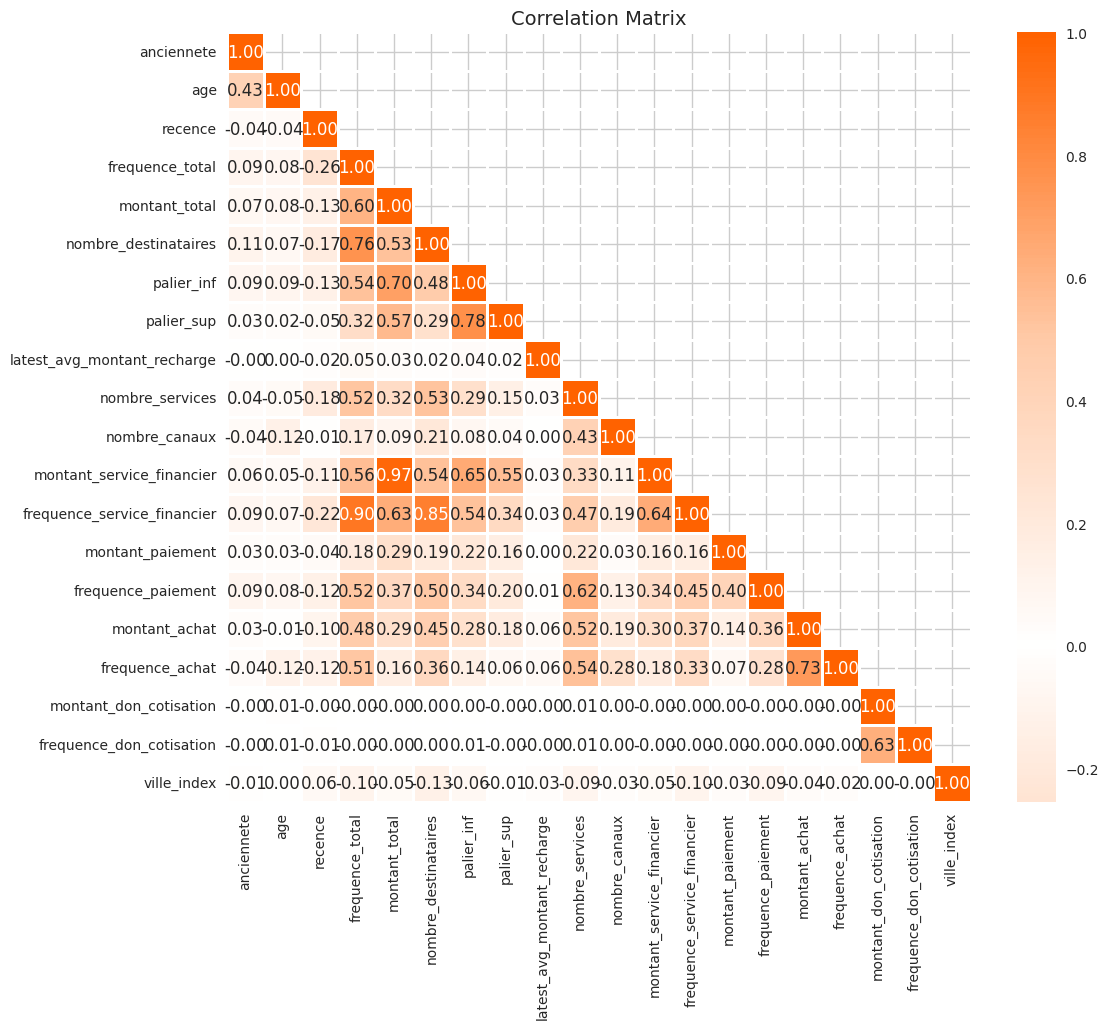

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
# Reset background style
sns.set_style('whitegrid')

# Calculate the correlation matrix excluding the 'CustomerID' column
corr = pd_kmeans_created.drop(columns=['numero']).corr()

# Define a custom colormap
colors = ['#ff6200', '#ffcaa8', 'white', '#ffcaa8', '#ff6200']
my_cmap = LinearSegmentedColormap.from_list('custom_map', colors, N=256)

# Create a mask to only show the lower triangle of the matrix (since it's mirrored around its
# top-left to bottom-right diagonal)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, cmap=my_cmap, annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

<div style="border-radius:10px; padding: 15px; background-color: #ffeacc; font-size:120%; text-align:left">
<h3 align="left"><font color=#ff6200>Inference: </font></h3>

Looking at the heatmap, we can see that there are some pairs of variables that have high correlations, for instance:

- `Monthly_Spending_Mean` and `Average_Transaction_Value`
    
    
- `Total_Spend` and `Total_Products_Purchased`

    
- `Total_Transactions` and `Total_Spend`
    
    
- `Cancellation_Rate` and `Cancellation_Frequency`
    
    
- `Total_Transactions` and `Total_Products_Purchased`

    
These high correlations indicate that these variables move closely together, implying a degree of multicollinearity.



<div style="border-radius:10px; padding: 15px; background-color: #ffeacc; font-size:120%; text-align:left">
    

Before moving to the next steps, considering the impact of multicollinearity on KMeans clustering, it might be beneficial to treat this multicollinearity possibly through dimensionality reduction techniques such as PCA to create a set of uncorrelated variables. This will help in achieving more stable clusters during the KMeans clustering process.

#### Normalisation

In [ ]:
# Initialize the StandardScaler
scaler = StandardScaler()

# List of columns that don't need to be scaled
columns_to_exclude = ['numero']

# List of columns that need to be scaled
columns_to_scale = pd_kmeans_created.columns.difference(columns_to_exclude)

# Copy the cleaned dataset
customer_data_scaled = pd_kmeans_created.copy()

# Applying the scaler to the necessary columns in the dataset
customer_data_scaled[columns_to_scale] = scaler.fit_transform(customer_data_scaled[columns_to_scale])

# Display the first few rows of the scaled data
customer_data_scaled.head()

,numero,anciennete,age,recence,frequence_total,montant_total,nombre_destinataires,palier_inf,palier_sup,latest_avg_montant_recharge,...,nombre_canaux,montant_service_financier,frequence_service_financier,montant_paiement,frequence_paiement,montant_achat,frequence_achat,montant_don_cotisation,frequence_don_cotisation,ville_index
0,1000001,0.951130,-0.550890,0.999182,-0.594734,-0.412438,-0.623487,-0.277548,-0.144280,-0.195130,...,0.601239,-0.362578,-0.494100,-0.148213,-0.439623,0.081342,-0.036486,-0.008269,-0.01312,0.774221
1,1000001,0.951130,-0.550890,0.999182,-0.594734,-0.412438,-0.623487,-0.277548,-0.144280,-0.195130,...,0.601239,-0.362578,-0.494100,-0.148213,-0.439623,0.081342,-0.036486,-0.008269,-0.01312,-0.363762
2,1000339,-1.540236,-0.809828,-0.530608,-0.856486,-0.420580,-0.623487,-0.450999,-0.144643,-0.209005,...,-1.651103,-0.361933,-0.570599,-0.148213,-0.439623,-0.607707,-0.724086,-0.008269,-0.01312,1.684607
3,1000708,-0.792826,-0.378265,-0.156660,0.399923,0.166404,-0.352717,0.961383,-0.141155,-0.048770,...,0.601239,-0.018188,0.270892,0.140060,-0.081843,-0.328706,-0.552186,-0.008269,-0.01312,0.091431
4,1000708,-0.792826,-0.378265,-0.156660,0.399923,0.166404,-0.352717,0.961383,-0.141155,-0.048770,...,0.601239,-0.018188,0.270892,0.140060,-0.081843,-0.328706,-0.552186,-0.008269,-0.01312,0.091431


#### Réduction de dimension avec ACP

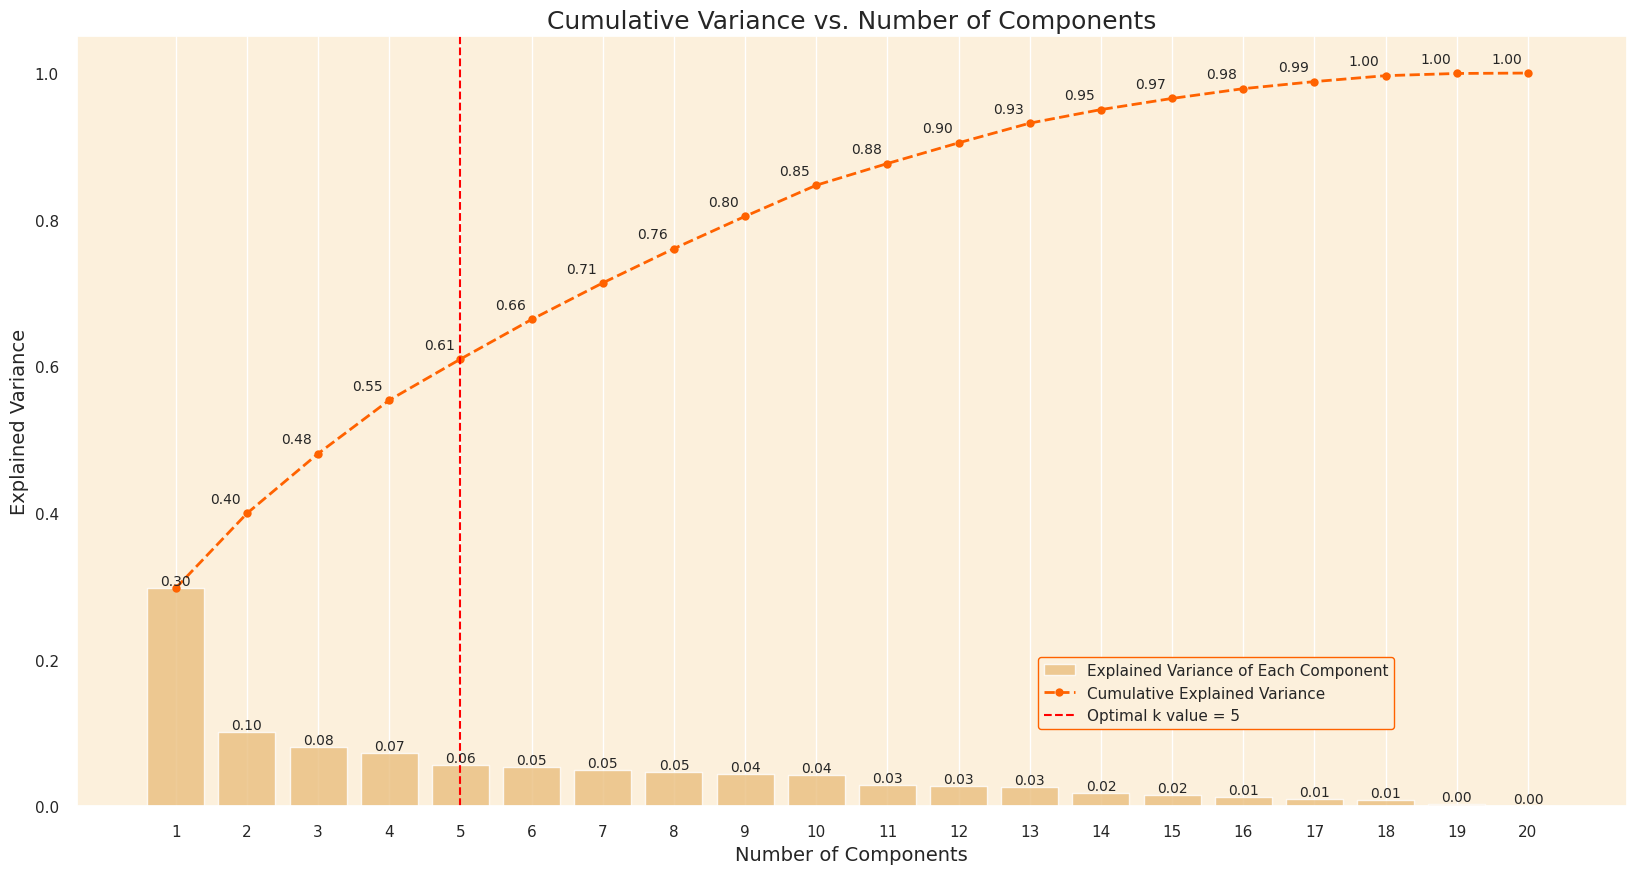

In [ ]:
# Setting CustomerID as the index column
customer_data_scaled.set_index('numero', inplace=True)

# Apply PCA
pca = PCA().fit(customer_data_scaled)

# Calculate the Cumulative Sum of the Explained Variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Set the optimal k value (based on our analysis, we can choose 6)
optimal_k = 5

# Set seaborn plot style
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

# Plot the cumulative explained variance against the number of components
plt.figure(figsize=(20, 10))

# Bar chart for the explained variance of each component
barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance) + 1)),
                      y=explained_variance_ratio,
                      color='#fcc36d',
                      alpha=0.8)

# Line plot for the cumulative explained variance
lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance,
                     marker='o', linestyle='--', color='#ff6200', linewidth=2)

# Plot optimal k value line
optimal_k_line = plt.axvline(optimal_k - 1, color='red', linestyle='--', label=f'Optimal k value = {optimal_k}')

# Set labels and title
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)

# Customize ticks and legend
plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles=[barplot.patches[0], lineplot, optimal_k_line],
           labels=['Explained Variance of Each Component', 'Cumulative Explained Variance', f'Optimal k value = {optimal_k}'],
           loc=(0.62, 0.1),
           frameon=True,
           framealpha=1.0,
           edgecolor='#ff6200')

# Display the variance values for both graphs on the plots
x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')
plt.show()

In [ ]:
# Creating a PCA object with 6 components
pca = PCA(n_components=6)

# Fitting and transforming the original data to the new PCA dataframe
customer_data_pca = pca.fit_transform(customer_data_scaled)

# Creating a new dataframe from the PCA dataframe, with columns labeled PC1, PC2, etc.
customer_data_pca = pd.DataFrame(customer_data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

# Adding the CustomerID index back to the new PCA dataframe
customer_data_pca.index = customer_data_scaled.index

# Displaying the resulting dataframe based on the PCs
customer_data_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
numero,,,,,,
1000001,-1.266068,0.167839,-0.031439,0.098841,-0.013403,1.106669
1000001,-1.210531,0.203251,-0.023819,0.015533,0.119633,0.394656
1000339,-2.173832,-0.737081,-0.087169,1.334064,-0.058920,0.151823
1000708,0.442416,-0.046528,-0.035346,0.860670,0.307232,-0.331542
1000708,0.442416,-0.046528,-0.035346,0.860670,0.307232,-0.331542


In [ ]:
# Define a function to highlight the top 3 absolute values in each column of a dataframe
def highlight_top3(column):
    top3 = column.abs().nlargest(3).index
    return ['background-color:  #ffeacc' if i in top3 else '' for i in column.index]

# Create the PCA component DataFrame and apply the highlighting function
pc_df = pd.DataFrame(pca.components_.T, columns=['PC{}'.format(i+1) for i in range(pca.n_components_)],
                     index=customer_data_scaled.columns)

pc_df.style.apply(highlight_top3, axis=0)

,PC1,PC2,PC3,PC4,PC5,PC6
anciennete,0.044823,-0.145482,0.024709,-0.616985,-0.073415,0.184543
age,0.028724,-0.216924,0.037544,-0.619325,-0.070682,0.151803
recence,-0.100640,-0.044161,-0.011355,0.146146,0.175878,0.398337
frequence_total,0.355308,0.068599,0.000171,-0.090595,-0.153903,-0.128224
montant_total,0.326810,-0.297678,-0.005496,0.135899,0.002796,0.026286
nombre_destinataires,0.335565,0.057253,0.005758,-0.103090,-0.081942,-0.165553
palier_inf,0.298411,-0.311406,0.000545,0.145275,-0.007527,0.086601
palier_sup,0.223767,-0.359588,-0.007078,0.253634,0.008735,0.169679
latest_avg_montant_recharge,0.022124,0.025124,-0.004008,0.017530,-0.252822,0.374617
nombre_services,0.273260,0.343569,0.007927,-0.048099,0.157103,0.042187


#### Nombre de clusters

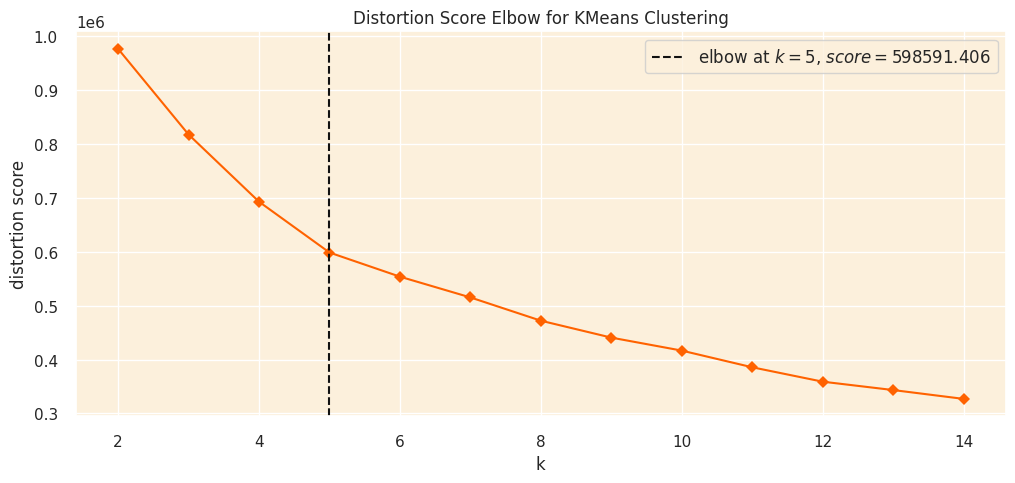

In [ ]:
# Set plot style, and background color
sns.set(style='darkgrid', rc={'axes.facecolor': '#fcf0dc'})

# Set the color palette for the plot
sns.set_palette(['#ff6200'])

# Instantiate the clustering model with the specified parameters
km = KMeans(init='k-means++', n_init=10, max_iter=100, random_state=0)

# Create a figure and axis with the desired size
fig, ax = plt.subplots(figsize=(12, 5))

# Instantiate the KElbowVisualizer with the model and range of k values, and disable the timing plot
visualizer = KElbowVisualizer(km, k=(2, 15), timings=False, ax=ax)

# Fit the data to the visualizer
visualizer.fit(customer_data_pca)

# Finalize and render the figure
visualizer.show();

In [ ]:
def silhouette_analysis(df, start_k, stop_k, figsize=(15, 16)):
    """
    Perform Silhouette analysis for a range of k values and visualize the results.
    """

    # Set the size of the figure
    plt.figure(figsize=figsize)

    # Create a grid with (stop_k - start_k + 1) rows and 2 columns
    grid = gridspec.GridSpec(stop_k - start_k + 1, 2)

    # Assign the first plot to the first row and both columns
    first_plot = plt.subplot(grid[0, :])

    # First plot: Silhouette scores for different k values
    sns.set_palette(['darkorange'])

    silhouette_scores = []

    # Iterate through the range of k values
    for k in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=0)
        km.fit(df)
        labels = km.predict(df)
        score = silhouette_score(df, labels)
        silhouette_scores.append(score)

    best_k = start_k + silhouette_scores.index(max(silhouette_scores))

    plt.plot(range(start_k, stop_k + 1), silhouette_scores, marker='o')
    plt.xticks(range(start_k, stop_k + 1))
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette score')
    plt.title('Average Silhouette Score for Different k Values', fontsize=15)

    # Add the optimal k value text to the plot
    optimal_k_text = f'The k value with the highest Silhouette score is: {best_k}'
    plt.text(10, 0.23, optimal_k_text, fontsize=12, verticalalignment='bottom',
             horizontalalignment='left', bbox=dict(facecolor='#fcc36d', edgecolor='#ff6200', boxstyle='round, pad=0.5'))


    # Second plot (subplot): Silhouette plots for each k value
    colors = sns.color_palette("bright")

    for i in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=0)
        row_idx, col_idx = divmod(i - start_k, 2)

        # Assign the plots to the second, third, and fourth rows
        ax = plt.subplot(grid[row_idx + 1, col_idx])

        visualizer = SilhouetteVisualizer(km, colors=colors, ax=ax)
        visualizer.fit(df)

        # Add the Silhouette score text to the plot
        score = silhouette_score(df, km.labels_)
        ax.text(0.97, 0.02, f'Silhouette Score: {score:.2f}', fontsize=12, \
                ha='right', transform=ax.transAxes, color='red')

        ax.set_title(f'Silhouette Plot for {i} Clusters', fontsize=15)

    plt.tight_layout()
    plt.show()

silhouette_analysis(customer_data_pca, 3, 12, figsize=(20, 50))

#### Entrainement du modele

In [ ]:
# Apply KMeans clustering using the optimal k
kmeans = KMeans(n_clusters=5, init='k-means++', n_init=10, max_iter=100, random_state=0)
kmeans.fit(customer_data_pca)

# Get the frequency of each cluster
cluster_frequencies = Counter(kmeans.labels_)

# Create a mapping from old labels to new labels based on frequency
label_mapping = {label: new_label for new_label, (label, _) in
                 enumerate(cluster_frequencies.most_common())}

# Reverse the mapping to assign labels as per your criteria
label_mapping = {v: k for k, v in {2: 1, 1: 0, 0: 2}.items()}

# Apply the mapping to get the new labels, handling the case where the key is not present
new_labels = np.array([label_mapping.get(label, label) for label in kmeans.labels_])

# Append the new cluster labels back to the original dataset
pd_kmeans_created['cluster'] = new_labels

# Append the new cluster labels to the PCA version of the dataset
customer_data_pca['cluster'] = new_labels

# Display the first few rows of the original dataframe
pd_kmeans_created.head()


,numero,anciennete,age,recence,frequence_total,montant_total,nombre_destinataires,palier_inf,palier_sup,latest_avg_montant_recharge,...,montant_service_financier,frequence_service_financier,montant_paiement,frequence_paiement,montant_achat,frequence_achat,montant_don_cotisation,frequence_don_cotisation,ville_index,cluster
0,1000001,14,33,92,9,58650.0,1,50000.0,80000.0,9699.333333,...,50500.0,5,0.0,0,8150.0,4,0.0,0,8.0,1
1,1000001,14,33,92,9,58650.0,1,50000.0,80000.0,9699.333333,...,50500.0,5,0.0,0,8150.0,4,0.0,0,3.0,1
2,1000339,4,30,2,4,51050.0,1,15000.0,29000.0,7560.333333,...,51050.0,4,0.0,0,0.0,0,0.0,0,12.0,1
3,1000708,7,35,24,28,598916.0,3,300000.0,520000.0,32263.333333,...,344050.0,15,36441.0,1,3300.0,1,0.0,0,5.0,1
4,1000708,7,35,24,28,598916.0,3,300000.0,520000.0,32263.333333,...,344050.0,15,36441.0,1,3300.0,1,0.0,0,5.0,1


#### Métrique d'évaluation

In [16]:
# Compute number of customers
num_observations = len(customer_data_pca)

# Separate the features and the cluster labels
X = customer_data_pca.drop('cluster', axis=1)
clusters = customer_data_pca['cluster']

# Compute the metrics
sil_score = silhouette_score(X, clusters)
calinski_score = calinski_harabasz_score(X, clusters)
davies_score = davies_bouldin_score(X, clusters)
wssse_score = kmeans.inertia_
adjusted_rand = adjusted_rand_score(clusters, kmeans.labels_)

# Create a table to display the metrics and the number of observations
table_data = [
    ["Number of Observations", num_observations],
    ["Silhouette Score", sil_score],
    ["Calinski Harabasz Score", calinski_score],
    ["Davies Bouldin Score", davies_score],
    ["Within-Cluster Sum of Squared Errors (WSSSE) Score", wssse_score],
    ["Adjusted Rand Score", adjusted_rand]
]

# Print the table
print(tabulate(table_data, headers=["Metric", "Value"], tablefmt='pretty'))


NameError: ignored

<div style="border-radius:10px; padding: 15px; background-color: #ffeacc; font-size:120%; text-align:left">
<h3 align="left"><font color=#ff6200>Clustering Quality Inference</font></h3>
    
    
- The __Silhouette Score__ of approximately 0.236, although not close to 1, still indicates a fair amount of separation between the clusters. It suggests that the clusters are somewhat distinct, but there might be slight overlaps between them. Generally, a score closer to 1 would be ideal, indicating more distinct and well-separated clusters.

    
- The __Calinski Harabasz Score__ is 1257.17, which is considerably high, indicating that the clusters are well-defined. A higher score in this metric generally signals better cluster definitions, thus implying that our clustering has managed to find substantial structure in the data.

    
- The __Davies Bouldin Score__ of 1.37 is a reasonable score, indicating a moderate level of similarity between each cluster and its most similar one. A lower score is generally better as it indicates less similarity between clusters, and thus, our score here suggests a decent separation between the clusters.


In conclusion, the metrics suggest that the clustering is of good quality, with clusters being well-defined and fairly separated. However, there might still be room for further optimization to enhance cluster separation and definition, potentially by trying other clustering and dimensionality reduction algorithms.



#### Cluster distribution

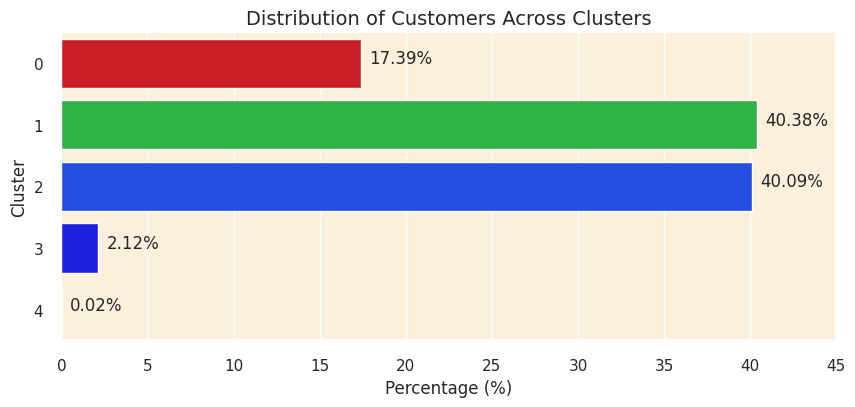

In [ ]:
# Calculate the percentage of customers in each cluster
cluster_percentage = (customer_data_pca['cluster'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']
cluster_percentage.sort_values(by='Cluster', inplace=True)

# Create a horizontal bar plot
plt.figure(figsize=(10, 4))
sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=colors)

# Adding percentages on the bars
for index, value in enumerate(cluster_percentage['Percentage']):
    plt.text(value+0.5, index, f'{value:.2f}%')

plt.title('Distribution of Customers Across Clusters', fontsize=14)
plt.xticks(ticks=np.arange(0, 50, 5))
plt.xlabel('Percentage (%)')

# Show the plot
plt.show()

#### Tendances centrales

##### Approche Radar

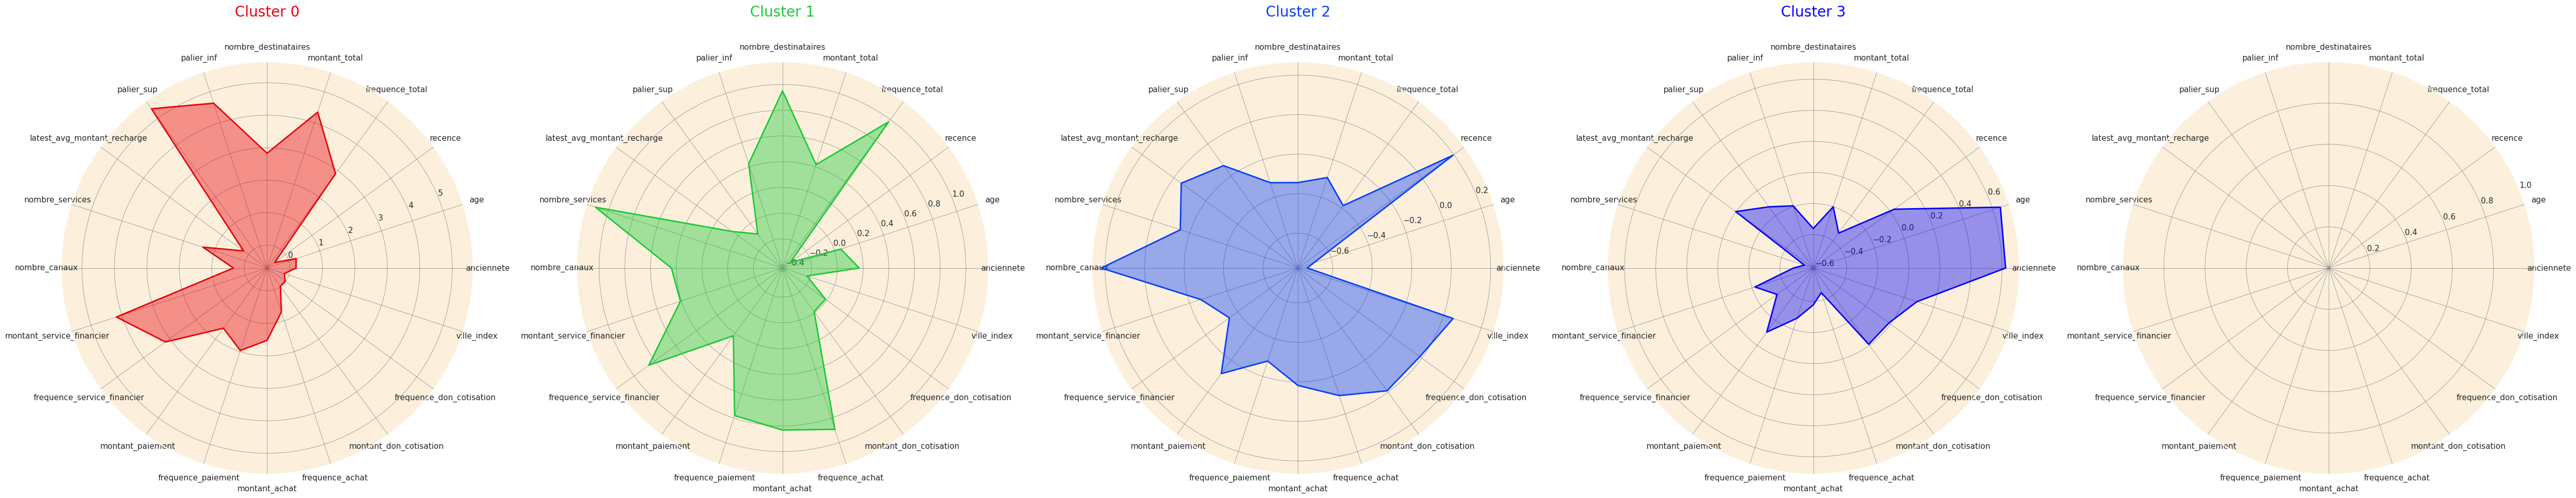

In [ ]:
# Setting 'CustomerID' column as index and assigning it to a new dataframe
df_customer =pd_kmeans_created.set_index('numero')

# Standardize the data (excluding the cluster column)
scaler = StandardScaler()
df_customer_standardized = scaler.fit_transform(df_customer.drop(columns=['cluster'], axis=1))

# Create a new dataframe with standardized values and add the cluster column back
df_customer_standardized = pd.DataFrame(df_customer_standardized, columns=df_customer.columns[:-1], index=df_customer.index)
df_customer_standardized['cluster'] = df_customer['cluster']

# Calculate the centroids of each cluster
cluster_centroids = df_customer_standardized.groupby('cluster').mean()

# Function to create a radar chart
def create_radar_chart(ax, angles, data, color, cluster):
    # Plot the data and fill the area
    ax.fill(angles, data, color=color, alpha=0.4)
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid')

    # Add a title
    ax.set_title(f'Cluster {cluster}', size=20, color=color, y=1.1)

# Set data
labels = np.array(cluster_centroids.columns)
num_vars = len(labels)

# Compute angle of each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is circular, so we need to "complete the loop" and append the start to the end
labels = np.concatenate((labels, [labels[0]]))
angles += angles[:1]

# Get the number of clusters dynamically
num_clusters = len(cluster_centroids)

# Initialize the figure
fig, ax = plt.subplots(figsize=(50, 30), subplot_kw=dict(polar=True), nrows=1, ncols=num_clusters)

# Create radar chart for each cluster
for i, color in enumerate(colors[:num_clusters]):  # Use only the required number of colors
    data = cluster_centroids.loc[i].tolist()
    data += data[:1]  # Complete the loop
    create_radar_chart(ax[i], angles, data, color, i)

# Add input data
for a in ax:
    a.set_xticks(angles[:-1])
    a.set_xticklabels(labels[:-1])

# Add a grid
for a in ax:
    a.grid(color='grey', linewidth=0.5)

# Display the plot
plt.tight_layout()
plt.show()


##### Approche Histogramme

In [ ]:
# Plot histograms for each feature segmented by the clusters
features = [
    'anciennete', 'age', 'recence', 'frequence_total', 'montant_total',
    'nombre_destinataires', 'palier_inf', 'palier_sup',
    'latest_avg_montant_recharge', 'nombre_services', 'nombre_canaux',
    'montant_service_financier', 'frequence_service_financier',
    'montant_paiement', 'frequence_paiement', 'montant_achat',
    'frequence_achat', 'montant_don_cotisation', 'frequence_don_cotisation',
    'ville_index'
]
clusters = pd_kmeans_created['cluster'].unique()
clusters.sort()

# Setting up the subplots
n_rows = len(features)
n_cols = len(clusters)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3*n_rows))

# Plotting histograms
for i, feature in enumerate(features):
    for j, cluster in enumerate(clusters):
        data = pd_kmeans_created[pd_kmeans_created['cluster'] == cluster][feature]
        axes[i, j].hist(data, bins=20, color=colors[j], edgecolor='w', alpha=0.7)
        axes[i, j].set_title(f'Cluster {cluster} - {feature}', fontsize=15)
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('')

# Adjusting layout to prevent overlapping
plt.tight_layout()
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assurez-vous que la colonne 'cluster' est de type catégorie pour des couleurs distinctes dans le graphique
pd_kmeans_created['cluster'] = pd_kmeans_created['cluster'].astype('category')

# Liste des features à inclure dans les sous-graphiques
features = [
    'anciennete', 'age', 'recence', 'frequence_total', 'montant_total',
    'nombre_destinataires', 'palier_inf', 'palier_sup',
    'latest_avg_montant_recharge', 'nombre_services', 'nombre_canaux',
    'montant_service_financier', 'frequence_service_financier',
    'montant_paiement', 'frequence_paiement', 'montant_achat',
    'frequence_achat', 'montant_don_cotisation', 'frequence_don_cotisation',
    'ville_index'
]

# Nombre de colonnes dans la disposition des subplots
num_cols = 4

# Calcul du nombre de lignes nécessaire pour afficher tous les subplots
num_rows = (len(features) + num_cols - 1) // num_cols

# Création de sous-graphiques avec des histogrammes pour chaque feature
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 4 * num_rows))

# Ajustement de l'espacement entre les subplots
plt.subplots_adjust(hspace=0.5)

# Boucle sur les features et création des histogrammes
for i, feature in enumerate(features):
    row = i // num_cols
    col = i % num_cols

    # Création de l'histogramme pour le feature et la couleur en fonction du cluster
    sns.histplot(data=pd_kmeans_created, x=feature, hue='cluster', kde=True, ax=axes[row, col])

    # Ajout d'un titre au subplot
    axes[row, col].set_title(f'Distribution de {feature} par cluster')

# Affichage du graphique
plt.show()


#### Profilage des segments

### Modèle 2 (MLLIB)

#### Nombre de clusters

In [ ]:
def elbow_method(df, feature_columns):
    # Assemble les caractéristiques en une seule colonne de vecteurs
    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    df_kmeans = assembler.transform(df)

    # Essayer différentes valeurs de k et évaluer leur coût
    cost = []
    for k in range(2, 11):
        kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
        model = kmeans.fit(df_kmeans)
        cost.append(model.summary.trainingCost)

    # Tracé du coût en fonction du nombre de clusters (méthode du coude)
    plt.plot(range(2, 11), cost, marker='o')
    plt.xlabel('Nombre de clusters (k)')
    plt.ylabel('Coût')
    plt.title('Méthode du Coude pour le k optimal')
    plt.show()
elbow_method(df_kmeans_created, km_feature_columns)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

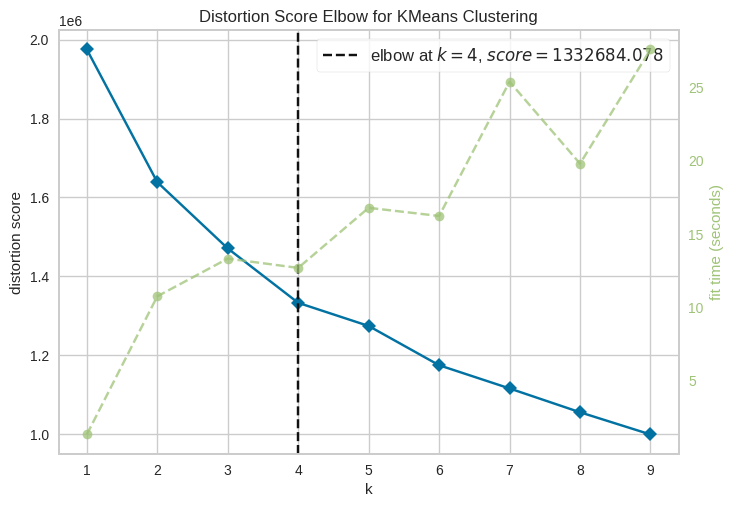

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from pyspark.sql import DataFrame

def visualize_elbow(pd_kmeans, feature_columns):
    # Sélectionner les colonnes RFM pour l'analyse

    kmeans_features = pd_kmeans[feature_columns]

    # Standardisation des caractéristiques
    scaler = StandardScaler()
    kmeans_features_scaled = scaler.fit_transform(kmeans_features)

    # Créer une instance du KElbowVisualizer
    visualizer = KElbowVisualizer(KMeans(random_state=42), k=(1, 10))

    # Ajuster le modèle et le visualizer
    visualizer.fit(kmeans_features_scaled)

    # Afficher le graphique
    visualizer.show()

# Exemple d'utilisation
visualize_elbow(pd_kmeans_created, km_feature_columns)

#### Entrainement

In [ ]:
from pyspark.ml.clustering import KMeans
def df_kmeans_model_train_save(df, feature_columns: list,  optimal_k: int, model_path: str):

    # Assemble the features into a single vector column
    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    df_kmeans = assembler.transform(df)

    # Initialize the K-Means model
    kmeans = KMeans().setK(optimal_k).setSeed(1).setFeaturesCol("features")

    # Fit the K-Means model to the data
    model = kmeans.fit(df_kmeans)

    # Save the K-Means model to the specified path
    model.write().overwrite().save(model_path)

    return model


In [ ]:
def df_kmeans_model_load(df, feature_columns, model_path):

    # Assemble les caractéristiques en une seule colonne de vecteurs
    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    df_kmeans = assembler.transform(df)

    # Charge le modèle K-Means sauvegardé
    model = KMeansModel.load(model_path)

    # Effectue la transformation des données
    clustered_df = model.transform(df_kmeans)

    # Renomme la colonne "prediction" en "Cluster" et supprime la colonne "features"
    clustered_df = clustered_df.withColumnRenamed("prediction", "Cluster").drop("features")

    return clustered_df


In [ ]:
model_path = "#models_OM/model_OM_Kmeans"  # Chemin de sauvegarde du modèle
optimal_k = 4  # Nombre optimal de clusters
df_kmeans_model_train_save(df_kmeans_created, km_feature_columns, optimal_k, model_path)

KMeansModel: uid=KMeans_f25f5b341eca, k=4, distanceMeasure=euclidean, numFeatures=20

In [ ]:
df_segment_valeur_kmeans = df_kmeans_model_load(df_kmeans_created, km_feature_columns, model_path)
pd_segment_valeur_kmeans=df_segment_valeur_kmeans.toPandas()
df_segment_valeur_kmeans.printSchema()

root
 |-- numero: string (nullable = true)
 |-- anciennete: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- recence: integer (nullable = true)
 |-- frequence_total: long (nullable = false)
 |-- montant_total: double (nullable = true)
 |-- nombre_destinataires: long (nullable = false)
 |-- palier_inf: double (nullable = true)
 |-- palier_sup: double (nullable = true)
 |-- latest_avg_montant_recharge: double (nullable = true)
 |-- nombre_services: integer (nullable = false)
 |-- nombre_canaux: integer (nullable = false)
 |-- montant_service_financier: double (nullable = true)
 |-- frequence_service_financier: long (nullable = true)
 |-- montant_paiement: double (nullable = true)
 |-- frequence_paiement: long (nullable = true)
 |-- montant_achat: double (nullable = true)
 |-- frequence_achat: long (nullable = true)
 |-- montant_don_cotisation: double (nullable = true)
 |-- frequence_don_cotisation: long (nullable = true)
 |-- ville_index: double (nullable = false)
 |-- 

#### Evaluation

##### Score

In [ ]:
def evaluate_kmeans_model(df_kmeans):
    # df_kmeans2 = df_kmeans.withColumnRenamed("cluster","prediction")

    # Evaluate the model using Silhouette score
    evaluator = ClusteringEvaluator(predictionCol="cluster")
    wssse = evaluator.evaluate(df_kmeans)
    print(f"Within Set Sum of Squared Errors (WSSSE) = {wssse}")

# Call the evaluation function with your DataFrame
evaluate_kmeans_model(df_segment_valeur_kmeans)


NameError: ignored

##### PCA

In [ ]:
from pyspark.ml.feature import PCA, VectorAssembler

# Choose a different name for the output column
assembler = VectorAssembler(
    inputCols=["anciennete", "age", "recence", "frequence_total", "montant_total",
               "nombre_destinataires", "palier_inf", "palier_sup",
               "latest_avg_montant_recharge", "nombre_services", "nombre_canaux",
               "montant_service_financier", "frequence_service_financier",
               "montant_paiement", "frequence_paiement", "montant_achat",
               "frequence_achat", "montant_don_cotisation",
               "frequence_don_cotisation", "ville_index"],
    outputCol="assembled_features"  # Change this to a new name
)

df_assembled = assembler.transform(df_segment_valeur_kmeans)

# Assuming you want to reduce the features to, say, 5 components
pca = PCA(k=2, inputCol="assembled_features", outputCol="pca_features")
model = pca.fit(df_assembled)
df_pca = model.transform(df_assembled)
# Rename the pca_features columns
df_pca = df_pca.withColumn("pca1", col("pca_features").getItem(0).alias("pca1"))
df_pca = df_pca.withColumn("pca2", col("pca_features").getItem(1).alias("pca2"))

# Select the relevant columns for display
df_pca.select("numero", "cluster", "pca1", "pca2").show()


In [ ]:
# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = df_pca.select("numero", "cluster", "pca_features").toPandas()

# Scatter plot
sns.scatterplot(x="pca_features[0]", y="pca_features[1]", hue="cluster", data=pandas_df)
plt.title("PCA Scatter Plot")
plt.show()


##### Silhouette score

In [ ]:
#Importing the model
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

silhouette_score=[]
final_data=df_segment_valeur_kmeans
evaluator = ClusteringEvaluator(predictionCol='prediction',
								featuresCol='scaledFeatures', \
								metricName='silhouette',
								distanceMeasure='squaredEuclidean')

for i in range(2,10):
	kmeans=KMeans(featuresCol='scaledFeatures', k=i)
	model=kmeans.fit(final_data)
	predictions=model.transform(final_data)
	score=evaluator.evaluate(predictions)
	silhouette_score.append(score)
	print('Silhouette Score for k =',i,'is',score)


In [ ]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt

plt.plot(range(2,10),silhouette_score)
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.title('Silhouette Score')
plt.show()


##### Visualisation des cluster K-Means

In [ ]:
# Définir la palette de couleurs
cluster_colors = ["green", "yellow", "red"]  # Vous pouvez personnaliser ces couleurs

# Créer le pairplot en utilisant la palette de couleurs
sns.set(style="ticks")
sns.pairplot(pd_segment_valeur_kmeans, hue="Cluster", palette=cluster_colors)

# Afficher le pairplot
plt.show()

#### Profilage des segments

In [ ]:
# df_kmeans =  (df_kmeans
#     .withColumn('Segment',
#         when(col('Cluster')==0, lit('Very High'))
#         .when(col('Cluster')==1, lit('High'))
#         .when(col('Cluster')==2, lit('Medium'))
#          .when(col('Cluster')==3, lit('Low'))
#         .otherwise(lit('Autre'))
#     )
# )

# df_kmeans.filter(col("Segment_service")=="Medium").show()

In [ ]:
pal = ['gold','#cc0000', '#ace600','#33cccc']
plt.figure(figsize=(13,8))
pl = sns.countplot(x=pd_segment_valeur_kmeans['Clusters'], palette= pal)
pl.set_title('Distribution Of The Clusters')
plt.show()

# **TESTS**

---



In [ ]:
# #Importation des CSV
# path='/content/drive/MyDrive/Colab/Segmentation/#datasets_OM'
# file_list=['2022_2.csv', '2022_3.csv','2022_4.csv','2022_5.csv','2022_6.csv','2022_7.csv',  '2022_8.csv', '2022_8.csv','2022_9.csv','2022_10.csv','2022_11.csv','2022_12.csv','2023_1.csv','2023_2.csv','2023_3.csv','2023_4.csv','2023_5.csv','2023_6.csv','2023_7.csv', ]
# df_agg = spark.read.csv(f'{path}/2022_1.csv', header=True)
# for csv_file in file_list:
#   df = spark.read.csv(f'{path}/{csv_file}', header=True, inferSchema=True)
#   df_agg = df_agg.union(df)

# df_agg.write.csv('#datasets_OM/trusted_om.base_transaction.csv', header=True, mode='overwrite')
# # df_agg.toPandas().to_csv('#datasets_OM/trusted_om.transactions.csv', index=False)
# # Show the RFM DataFrame
# df_agg.show()

In [ ]:
#!git clone https://github.com/asish012/dataanalytics.git